# Figure 3:  RNA and ATAC, P9855

Here we study the chromatin accessibility (ATAC peak heights), gene expression (mRNA counts), and a bit of protein abundance for experiment P9855.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [9]:
import matplotlib.font_manager as fm

font = fm.FontProperties(
        family = 'Helvetica', fname = '/System/Library/Fonts/Helvetica.ttc')

In [12]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

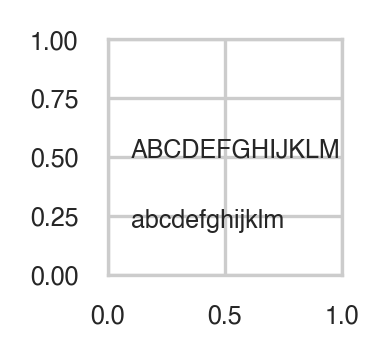

In [13]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

# Loading data

In [14]:
import anndata

adata = anndata.read_loom('../Data/Processed/P9855.loom')
adata.var_names = adata.var['gene_name']
adata.obs_names = adata.obs['obs_names']

prot_data = anndata.read_loom('../Data/Processed/P9855_protein.loom')
prot_data.var_names = prot_data.var['var_names']
prot_data.obs_names = prot_data.obs['obs_names']

ATAC_data = anndata.read_loom('../Data/Processed/P9855_ATAC.loom')
ATAC_data.var_names = ATAC_data.var['PeakID']
ATAC_data.obs_names = ATAC_data.obs['Sample_name']

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
adata

AnnData object with n_obs × n_vars = 70 × 11881
    obs: 'Clone_ID', 'Good clone', 'Number_Of_Cells', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'ENSG', 'F_pval', 'GC_content', 'TSS', 'chr', 'dir', 'end', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'start', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [16]:
prot_data

AnnData object with n_obs × n_vars = 24213 × 8
    obs: 'Clone_ID', 'Clone_Name_Well_ID', 'FSC-A', 'FSC-H', 'FSC-W', 'Numerical_ID', 'Plate', 'SSC-A', 'SSC-H', 'SSC-W', 'SampleID', 'obs_names'
    var: 'gene', 'var_names'

In [17]:
ATAC_data

AnnData object with n_obs × n_vars = 29 × 80599
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

In [18]:
ATACR_data = ATAC_data[ATAC_data.obs['Is_replicate'] == True, :]
ATACR_data

View of AnnData object with n_obs × n_vars = 12 × 80599
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

# Quick ATAC plotting tool

We create a quick exploratory tool for plotting ATAC peaks, focusing on clones with replicates, and the sister clones 5a/5b.  We assign a modified clone label, for coloring purposes.

In [19]:
clones_focus = ['1', '15', '22', '23', '8', '9', '5a', '5b']

def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip in clones_focus:
        return cl_strip #'Clone '+cl_strip[5:]
    else:
        return 'Other'

ATAC_data.obs['colorclone'] = ATAC_data.obs['ATAC_clone'].map(lambda cl : clone_rename(cl))


In [20]:
def ATAC_plot(peak):
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    sns.set_style('whitegrid')
    peak_heights = pd.DataFrame(ATAC_data.to_df()[peak])
    peak_heights.columns = ['height']
    peak_heights['parent'] = ATAC_data.obs.ATAC_clone.apply(lambda c : c.split('_')[0])
    peak_heights['hue'] = ATAC_data.obs.colorclone
    sns.scatterplot(x='parent', y='height', color='gray', data=peak_heights[peak_heights['hue'] == 'Other'], 
                    legend=False, ax=ax,s=100)
    
    sns.scatterplot(x='parent', y='height', hue='hue', edgecolor='k',
                    data=peak_heights[peak_heights['hue'] != 'Other'], 
                    legend=False, ax=ax, s=100)
    
    ax.set_ylabel('Peak height')
    ax.set_xlabel('Clone')
    plt.suptitle('Heights (pseudolog-normalized) for {}'.format(peak))
    plt.show()

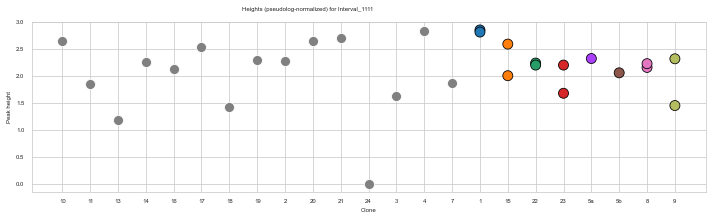

In [21]:
ATAC_plot('Interval_1111')

# Quick figure, IL2RG

By popular demand, here's a little figure related to IL2RG:  population and clonal expression.

In [22]:
IL2RG = adata.to_df()['IL2RG']
IL2RG

obs_names
P9855_2001    7.654436
P9855_2002    7.852678
P9855_2003    8.214191
P9855_2004    7.992360
P9855_2005    8.090677
                ...   
P9855_2078    7.712408
P9855_2079    7.539834
P9855_2080    7.655730
P9855_2081    7.998237
P9855_2082    8.375481
Name: IL2RG, Length: 70, dtype: float32

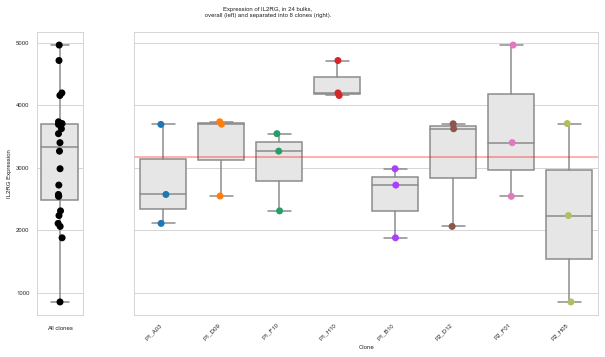

In [23]:
fig,ax = plt.subplots(1,2, sharey = True, figsize=(10,5), 
                      gridspec_kw = {'width_ratios':[1,10]})

allplot_df = pd.DataFrame(np.exp(IL2RG) - 1) # Remove log-normalization.
#allplot_df = pd.DataFrame(IL2RG) # Use log-normalized data?
allplot_df.columns=['IL2RG Expression']
allplot_df['Clone'] = adata.obs['Clone_ID']
allmean = allplot_df['IL2RG Expression'].median()

randclones = allplot_df['Clone'].value_counts()[:8].index
allplot_df = allplot_df[allplot_df['Clone'].isin(randclones)]

sns.boxplot(y='IL2RG Expression', color=(0.9,0.9,0.9,1), data = allplot_df, ax=ax[0], orient='v', whis=np.inf)
sns.stripplot(y='IL2RG Expression', color='black', data = allplot_df, 
              jitter=0.05, ax=ax[0], orient='v',s=7.0)

sns.boxplot(y='IL2RG Expression', x='Clone', color=(0.9,0.9,0.9,1), data = allplot_df, 
            ax=ax[1], orient='v', whis=np.inf)

sns.stripplot(y='IL2RG Expression', x='Clone', hue='Clone', data = allplot_df, 
              jitter=0.05, ax=ax[1], orient='v',s=7.0)

ax[0].set_xlabel('All clones')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha="right")
ax[1].axhline(allmean, color=(1,0,0,0.4))
ax[1].set_ylabel('')
ax[1].legend_.remove()

plt.suptitle('Expression of IL2RG, in {} bulks,'
             '\n overall (left) and separated into {} clones (right).'.format(len(allplot_df), len(allplot_df['Clone'].unique())))
plt.show()

# Panel:  UMAP Clustering based on ATAC peak heights

We cluster bulks by ATAC peaks using UMAP here.

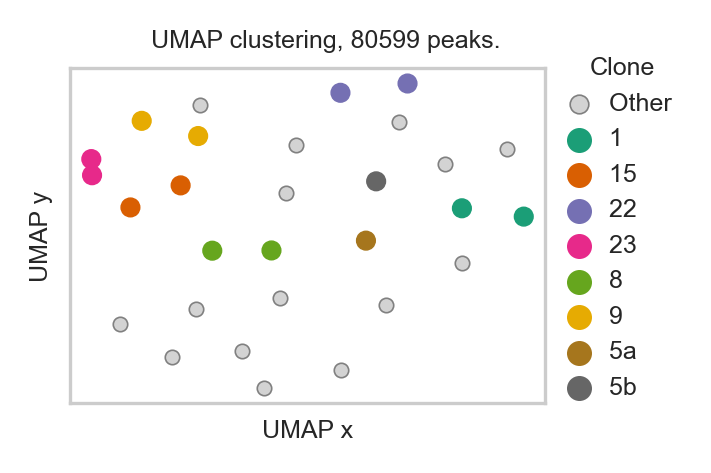

In [29]:
n_components = 20
n_neighbors = 10
min_dist = 0.25

mm = 1/25.4
figsize = (60*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
hue_order = ['  ' + hue for hue in hue_order]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = '  ' + y
#display(cl_df)

sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == '  Other'], s=12, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='  Other')

sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != '  Other'], s=20, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.1), ncol=1, framealpha=0.0, title='Clone')

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [20]
for j in range(1,9):
    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("UMAP clustering, {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/UMAP.pdf", bbox_inches='tight')

plt.show()

## Supplement? -- varying the UMAP parameters

Now we vary the UMAP parameters through 27 different choices, and look at the resulting distance (in the UMAP plane) between clones, replicates, and the sister clones.

In [34]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist

n_comp_array = [5,10,20] # PCA components.  Can't be more than the number of samples!
n_neigh_array = [3,5,10]
min_dist_array = [0.1, 0.25, 0.5]


X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]

dist_df = pd.DataFrame(index=range(len(n_comp_array)*len(n_neigh_array)*len(min_dist_array)), 
                       columns=['n_components','n_neighbors','min_dist','rep_dist','sis_dist','nonrep_dist'])

j = 0
dm = {}
for n_components in n_comp_array:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    for n_neighbors in n_neigh_array:
        for min_dist in min_dist_array:
            X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                                   random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

            cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
            cl_df.index = 'clone' + ATAC_data.obs['ATAC_clone']
            #cl_df['Clone'] = y
            dm[j] = pd.DataFrame(distance_matrix(cl_df.values, cl_df.values), index=cl_df.index, columns=cl_df.index)
            
            #dm[j].index = 'clone' + ATAC_data.obs['ATAC_clone']
            #dm[j].columns = 'clone' + ATAC_data.obs['ATAC_clone']
            #display(dm[j])
            rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
            nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
                      ['clone'+num for num in clr_list]]
            dm_nonrep = dm[j].loc[nonreps][nonreps]
            nonrep_dist = dm_nonrep.values.flatten().mean()
            sis_dist = dm[j].loc['clone5a_R1','clone5b_R1']
            dist_df.loc[j] = {'n_components':n_components,
                             'n_neighbors':n_neighbors,
                             'min_dist':min_dist,
                             'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                             'sis_dist':sis_dist / nonrep_dist.mean(),
                             'nonrep_dist':nonrep_dist}
            j += 1
display(dist_df)
        

,n_components,n_neighbors,min_dist,rep_dist,sis_dist,nonrep_dist
0,5.0,3.0,0.1,0.029965,0.063607,11.670293
1,5.0,3.0,0.25,0.066201,0.130472,7.457741
2,5.0,3.0,0.5,0.087924,0.150711,8.135579
3,5.0,5.0,0.1,0.093704,0.070553,3.720797
4,5.0,5.0,0.25,0.163171,0.148305,2.986336
5,5.0,5.0,0.5,0.216745,0.219084,3.522098
6,5.0,10.0,0.1,0.261993,0.239529,1.752155
7,5.0,10.0,0.25,0.285973,0.247535,1.960293
8,5.0,10.0,0.5,0.327026,0.359838,2.285854
9,10.0,3.0,0.1,0.034806,0.041443,9.714969


In [35]:
print('The mean UMAP distance between replicate clones is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.rep_dist.mean(), dist_df.rep_dist.std()))

print('The mean UMAP distance between sister clones 5a/5b is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.sis_dist.mean(), dist_df.sis_dist.std()))

The mean UMAP distance between replicate clones is 19.5% +/- 11.6% of the mean non-replicate distance.
The mean UMAP distance between sister clones 5a/5b is 21.9% +/- 13.5% of the mean non-replicate distance.


In [38]:
ATAC_df = ATAC_data.to_df()
ATAC_df.index = 'clone'+ATAC_data.obs['ATAC_clone']
ATAC_df = ATAC_df.T

In [39]:
X = ATAC_df.T
pca = PCA(n_components=20)
X_PCA = pca.fit_transform(X)
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X_PCA, X_PCA), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist         0.059615
sis_dist         0.985023
nonrep_dist    194.908331
dtype: float64

In [40]:
#X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X.values, X.values), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist         0.620445
sis_dist         0.942482
nonrep_dist    205.066003
dtype: float64

In [41]:
def upper_values(sq_df):
    n = len(sq_df)
    if sq_df.shape != (n,n):
        print('Not square!')
        return None
    index_list = [[i,j] for i in range(n) for j in range(n) if j > i]
    return np.array([sq_df.values[il[0],il[1]] for il in index_list])

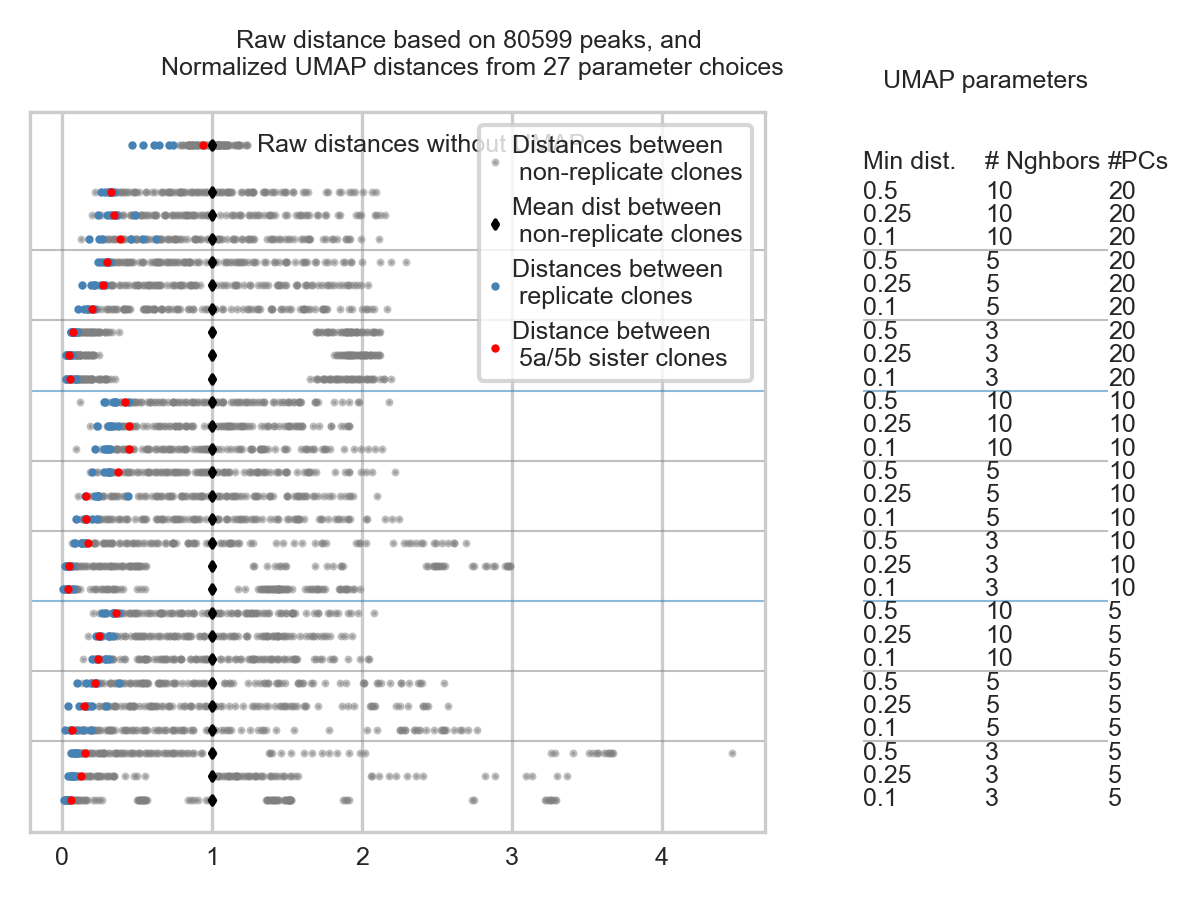

In [42]:
dist_df['Distance between replicates'] = dist_df['rep_dist'] / dist_df['nonrep_dist']
dist_df['Distance between 5a/5b'] = dist_df['sis_dist'] / dist_df['nonrep_dist']

fig,ax = plt.subplots(1,2,figsize=(4, 3.0), dpi=300, sharey=True,
                     gridspec_kw = {'width_ratios':[3,1]})
fig.subplots_adjust(hspace=-2)
sns.set_style('white')
setfontsize()

# First, the non-UMAP distances.
dd = dist_raw_df
nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
           ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = upper_values(dm_nonrep) # All distances between distinct non-replicates
nonrep_dist = nonrep_dist / nonrep_dist.mean()
    
ax[0].scatter(nonrep_dist,[28]*len(nonrep_dist), s=0.8, color='gray', alpha=0.5) #, 
              # label = 'Distances between \n non-replicate clones')
ax[0].scatter(1.0, 28, s=2, color='k', marker='d') #, label='Mean dist between \n non-replicate clones')
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] 
                     for num in ['1','15','22','23','8','9']])
rep_dist = rep_dist / dd.nonrep_dist
ax[0].scatter(rep_dist,[28]*len(rep_dist), s=1, color='steelblue') #, 
              #label = 'Distances between \n replicate clones')
ax[0].scatter(dd.sis_dist,28, s=1, color='red', marker='o') #, 
              #label = 'Distance between \n 5a/5b sister clones')

for j in dist_df.index:
    dd = dist_df.loc[j]
    
    # First, the nonreplicates.
    dm_nonrep = dm[j].loc[nonreps][nonreps]
    nonrep_dist = upper_values(dm_nonrep) # All distances between distinct non-replicates
    nonrep_dist = nonrep_dist / nonrep_dist.mean()
    
    ax[0].scatter(nonrep_dist,[j]*len(nonrep_dist), s=0.8, color='gray', alpha=0.5, 
               label = 'Distances between \n non-replicate clones')
    
    ax[0].scatter(1.0, j, s=2, color='k', marker='d', label='Mean dist between \n non-replicate clones')
    
    # Then, the replicates.
    rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] 
                         for num in ['1','15','22','23','8','9']])
    rep_dist = rep_dist / dd.nonrep_dist
    ax[0].scatter(rep_dist,[j]*len(rep_dist), s=1, color='steelblue', 
              label = 'Distances between \n replicate clones')
    
    # Finally, the sisters 5a/5b.
    ax[0].scatter(dd.sis_dist,j, s=1, color='red', marker='o', 
              label = 'Distance between \n 5a/5b sister clones')
    
    if j == 0:
        ax[0].legend(loc = 'upper right')
    
    ax[1].text(1.0,j,int(dist_df.loc[j,'n_components']),ha='left',va='center')
    ax[1].text(0.5,j,int(dist_df.loc[j,'n_neighbors']),ha='left',va='center')
    ax[1].text(0,j,dist_df.loc[j,'min_dist'],ha='left',va='center')

ax[0].axhline(8.5, linewidth=0.5, alpha=0.5)
ax[1].axhline(8.5, linewidth=0.5, alpha=0.5)
ax[0].axhline(17.5, linewidth=0.5, alpha=0.5)
ax[1].axhline(17.5, linewidth=0.5, alpha=0.5)

for yoff in [0, 9, 18]:
    for yoff2 in [2.5, 5.5]:
        for j in [0,1]:
            ax[j].axhline(yoff+yoff2, linewidth=0.5, alpha=0.5, color='gray')
        
ax[1].axis('off')

ax[0].text(1.3,28, 'Raw distances without UMAP', ha='left', va='center')
ax[1].text(0,27,'Min dist.', ha='left')
ax[1].text(0.5,27,'# Nghbors', ha='left')
ax[1].text(1,27,'#PCs', ha='left')
ax[1].set_title('UMAP parameters')
ax[0].set_yticks([])
ax[0].tick_params(axis='x', which='major', pad=0)

plt.suptitle('Raw distance based on {} peaks, and \n'
             'Normalized UMAP distances from '
            '27 parameter choices'.format(len(X.T)), y=1)

set_size(fig, (4, 3.0))
plt.savefig("Panels/UMAP_dist.pdf", bbox_inches='tight')

plt.show()

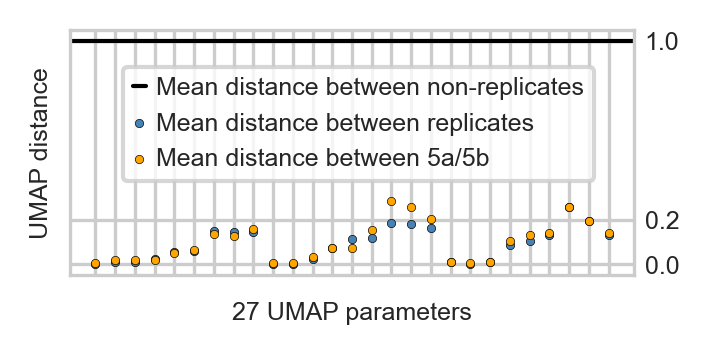

In [47]:
figsize=(60*mm,30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()
sns.set_style('whitegrid')

plot_df = dist_df.copy()
plot_df['Parameter'] = dist_df['n_components'].astype(int).astype(str)+', '
plot_df['Parameter'] += dist_df['n_neighbors'].astype(int).astype(str)+', '
plot_df['Parameter'] +=  dist_df['min_dist'].astype(str).apply(lambda s : s[1:])
sns.scatterplot(y = 'Distance between replicates', x='Parameter', data=plot_df, 
                s=4, edgecolor='k', color='steelblue', ax=ax, label='Mean distance between replicates')
sns.scatterplot(y = 'Distance between 5a/5b', x='Parameter', data=plot_df, 
                s=4, edgecolor='k', color='orange', ax=ax, label='Mean distance between 5a/5b')

ax.axhline(1.0, label='Mean distance between non-replicates', color='k', linewidth=1)
ax.legend(bbox_to_anchor=(0.95, 0.9))
ax.set_ylabel('UMAP distance')
ax.set_xticklabels([])
ax.set_xlabel('27 UMAP parameters')
ax.set_yticks([0,0.2,1])
ax.tick_params(axis='both', pad=-1)
ax.tick_params(axis='y', labelright=True, labelleft=False)

set_size(fig, figsize)
plt.savefig("Panels/UMAP_params.pdf", bbox_inches='tight')

plt.show()

#  Clonal peak variability

Here we look at clonal peak variability, among the replicate clones.  The replicate clones offer a method for simultaneous quality control and variability assessment.  We put the replicate peak heights into a dataframe first.

In [48]:
AR_df = ATACR_data.to_df()
AR_df.index = ATACR_data.obs.ATAC_clone
AR_df

PeakID,Interval_77062,Interval_18293,Interval_51938,Interval_33832,Interval_13433,Interval_48454,Interval_27763,Interval_53540,Interval_46169,Interval_46787,...,Interval_58433,Interval_62113,Interval_45676,Interval_43639,Interval_35777,Interval_8387,Interval_17712,Interval_31505,Interval_18056,Interval_10427
ATAC_clone,,,,,,,,,,,,,,,,,,,,,
1_R1,2.220971,0.000000,2.315422,2.116660,5.671244,2.401717,3.377605,3.313264,0.648631,0.000000,...,2.000187,2.116660,3.090913,0.648631,1.318754,4.115008,2.401717,1.038805,2.116660,0.648631
1_R2,2.574305,0.793996,2.743844,2.183737,5.564601,1.533994,3.179393,3.153849,1.230938,0.000000,...,2.370034,1.954600,3.073051,0.473815,0.000000,4.387019,1.230938,1.393903,1.864853,0.000000
15_R1,2.335525,0.000000,2.683983,2.465641,5.688357,1.796163,3.665038,0.890413,1.523954,0.000000,...,2.335525,1.353842,3.014939,0.541200,0.000000,2.979083,1.669292,1.908734,1.908734,0.000000
15_R2,2.405284,0.000000,3.251001,2.472925,5.707511,2.536280,3.984053,0.574085,1.411480,0.000000,...,2.332733,1.584639,2.893762,0.574085,0.574085,3.416717,1.411480,0.936490,1.584639,0.574085
22_R1,2.244406,1.991444,1.836056,1.836056,5.708737,2.244406,3.383287,1.836056,1.134205,0.000000,...,2.883102,1.652000,1.134205,0.719960,1.836056,3.577769,1.426249,1.426249,1.134205,0.000000
22_R2,3.193007,1.524770,2.102691,2.843361,5.701477,1.986456,3.479647,1.307133,1.524770,0.641075,...,2.387270,1.986456,2.301105,0.641075,1.854911,4.069119,2.206811,1.028563,2.102691,0.641075
23_R1,1.966361,0.000000,1.506567,1.684364,5.644652,1.290173,3.610647,0.000000,1.684364,0.000000,...,2.445269,1.290173,2.186078,0.000000,0.000000,3.966331,1.835270,1.684364,1.966361,0.000000
23_R2,2.089187,0.000000,2.495113,2.207124,5.422726,1.618351,3.594341,1.106046,1.106046,0.000000,...,2.649396,1.394653,1.955457,0.000000,1.106046,3.839530,2.089187,1.801043,1.106046,0.000000
8_R1,2.349192,0.465191,1.845438,2.404186,5.449306,1.515987,3.879200,3.382059,0.781450,0.000000,...,2.641270,1.376647,1.934876,0.000000,1.214698,3.983718,2.722325,1.214698,2.092830,0.000000


This data contains 12 samples, with 2 bulks from each clone.  These 2 bulks are considered replicates (R1 and R2).

In [49]:
parents = ATACR_data.obs.ATAC_parent.unique()
parents

array(['1', '15', '22', '23', '8', '9'], dtype=object)

We examine the general distribution of replicate pairs, by "melting" the dataframe above.

In [50]:
AR_mins = pd.DataFrame(columns=AR_df.columns, index=parents)
AR_maxs = pd.DataFrame(columns=AR_df.columns, index=parents)
for cp in parents:
    AR_both = AR_df.loc[[cp+'_R1',cp+'_R2']]
    AR_mins.loc[cp] = AR_both.min()
    AR_maxs.loc[cp] = AR_both.max()

minmelt = AR_mins.melt()
mindiff_df = pd.DataFrame(minmelt.value, index=minmelt.index)
mindiff_df.columns = ['min_value']

mindiff_df['Diff'] = (AR_maxs - AR_mins).melt().value.astype(float)

val_max = mindiff_df.min_value.max() + 0.01
int_size = (val_max - 0.01) / 10
tuple_list = [(a+1e-10,a+int_size) for a in np.arange(0.01,val_max,int_size)]

bins = pd.IntervalIndex.from_tuples([(0,0.01)] + tuple_list, closed='left')
mindiff_df['Cut'] = pd.cut(mindiff_df.min_value, bins=bins)

bigdiffs = mindiff_df.groupby('Cut').Diff.quantile(0.99).astype(float)
mindiff_df['bigdiff'] = mindiff_df.Cut.map(bigdiffs).astype(float)

mindiff_df['badpeak'] = (mindiff_df.Diff > mindiff_df.bigdiff)

mindiff_df['PeakID'] = minmelt['PeakID']

mindiff_df

,min_value,Diff,Cut,bigdiff,badpeak,PeakID
0,2.220971,0.353334,"[1.976722536187036, 2.6322967147827145)",0.854268,False,Interval_77062
1,2.335525,0.069759,"[1.976722536187036, 2.6322967147827145)",0.854268,False,Interval_77062
2,2.244406,0.948601,"[1.976722536187036, 2.6322967147827145)",0.854268,True,Interval_77062
3,1.966361,0.122825,"[1.3211483574913574, 1.9767225360870362)",1.071294,False,Interval_77062
4,2.349192,0.415596,"[1.976722536187036, 2.6322967147827145)",0.854268,False,Interval_77062
...,...,...,...,...,...,...
483589,0.0,0.574085,"[0.0, 0.01)",1.703403,False,Interval_10427
483590,0.0,0.641075,"[0.0, 0.01)",1.703403,False,Interval_10427
483591,0.0,0.000000,"[0.0, 0.01)",1.703403,False,Interval_10427
483592,0.0,0.000000,"[0.0, 0.01)",1.703403,False,Interval_10427


This produces about a half-million replicate-pair peak heights.  We organize each pair by the lowest peak height (among the two in the pair) and the difference in peak heights.

NameError: name 'cuts' is not defined

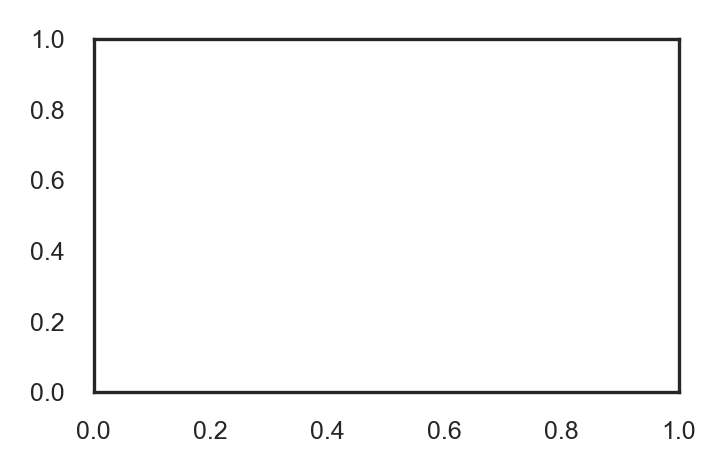

What we see is that replicate pairs (R1/R2) within a clone tend to have very close peak heights.  E.g., if the minimum peak height is 3, the maximum peak height is typically less than 3.5, and almost always less than 4.0.

We can use this for quality control, throwing out peaks in which a replicate pair exhibits distant peak heights.  We give each peak a "quality p-value" based on the most distant of the replicate pairs.  If the most distant of the replicate pairs is in the 99th percentile (in peak-height difference), then the quality p-value would be 0.01.  

In [52]:
diff_df = {}
md_df = {}
ATAC_data.var['quality_p'] = 1.0
cuts = mindiff_df['Cut'].unique()

for cut in cuts:
    md_df[cut] = mindiff_df[mindiff_df['Cut'] == cut].copy()
    diff_df[cut] = md_df[cut].Diff.sort_values()
    md_df[cut]['ss'] = np.searchsorted(diff_df[cut], md_df[cut].Diff)
    num_samps = len(diff_df[cut])
    md_df[cut]['p_val'] = 1 - (md_df[cut]['ss'] / (1 + num_samps))
    qp_series = md_df[cut].groupby('PeakID').p_val.min()
    ATAC_data.var.loc[qp_series.index, 'quality_p'] = qp_series
    
ATAC_data.var

,PeakID,chr,end,in_ensg,in_gene,itype,mid,start,quality_p
PeakID,,,,,,,,,
Interval_77062,Interval_77062,9,115080094,ENSG00000119314,PTBP3,intron,115079731.5,115079369,0.104812
Interval_18293,Interval_18293,12,117544007,ENSG00000258285,RP11-103B5.2,intron,117543889.5,117543772,0.521875
Interval_51938,Interval_51938,3,156852899,None,nan,Intergen,156852750.0,156852601,0.028644
Interval_33832,Interval_33832,19,1672563,None,nan,Intergen,1672247.0,1671931,0.016356
Interval_13433,Interval_13433,11,82997741,ENSG00000137500,CCDC90B,promoter-TSS,82997180.5,82996620,0.010913
...,...,...,...,...,...,...,...,...,...
Interval_8387,Interval_8387,10,33624658,ENSG00000099250,NRP1,promoter-TSS,33623619.5,33622581,0.067399
Interval_17712,Interval_17712,12,96890243,ENSG00000188596,C12orf55,intron,96889859.5,96889476,0.029034
Interval_31505,Interval_31505,17,73744122,ENSG00000132470,ITGB4,intron,73744009.0,73743896,0.076459


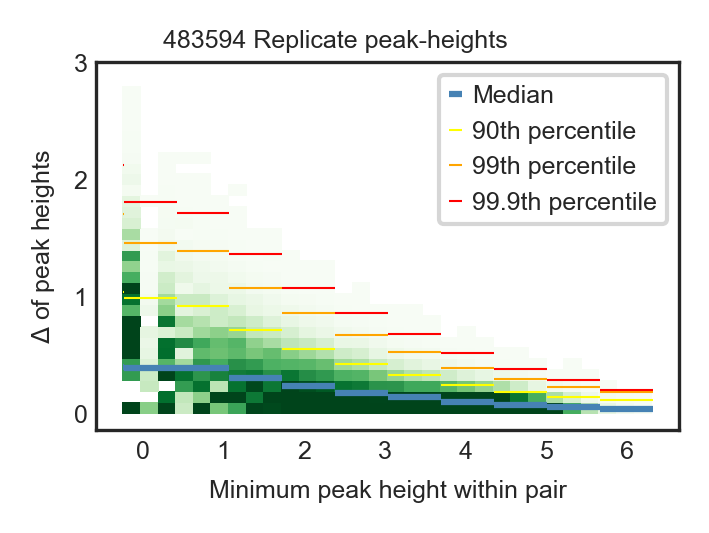

In [54]:
from matplotlib import collections  as mc

sns.set_style('white')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()
qcols = {0.5:'steelblue', 0.9:'yellow', 0.99:'orange', 0.999:'red'}
for quant in qcols.keys():
    diffs = mindiff_df.groupby('Cut').quantile(quant).Diff
    lines = [[(cut.left, diffs[cut]), (cut.right, diffs[cut])] for cut in cuts]
    if quant == 0.5:
        label = 'Median'
        lw = 1.5
    else:
        if quant < 0.999:
            label = '{:1.0f}th percentile'.format(quant*100)
        else:
            label = '{:1.1f}th percentile'.format(quant*100)
        lw = 0.5
    lc = mc.LineCollection(lines, linewidths=lw, color=qcols[quant], label=label)
    ax.add_collection(lc)
ax.legend()    

sns.histplot(x='min_value', y='Diff', data=mindiff_df, bins=30, pmax=0.5, 
             cmap='Greens', cbar=False)


plt.suptitle('{} Replicate peak-heights'.format(len(mindiff_df)))
ax.set_xlabel('Minimum peak height within pair')
ax.set_ylabel('$\Delta$ of peak heights')
ax.set_xticks([x + 0.25 for x in [0,1,2,3,4,5,6]])
ax.set_xticklabels(['0','1','2','3','4','5','6'], y=0.05)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['0','1','2','3'], x=0.035)

set_size(fig, figsize)
plt.savefig("Panels/Diff_dist.pdf", bbox_inches='tight')

plt.show()

The "quality_p" column is very low (close to zero) when the peak height difference is very high when looking at one of the replicate pairs.  We might exclude those with quality_p < 0.05, for quality control purposes.

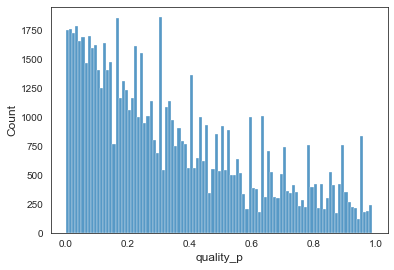

In [55]:
desetfontsize()
sns.histplot(ATAC_data.var.quality_p, bins=np.arange(0,1,0.01))
plt.show()

Note that the distribution of quality p-values is not flat (as one would expect for p-values), since we are taking the minimum p-value among 6 (one for each of the six replicate pairs).

We perform similar analysis to say whether a peak exhibits variability between replicate clones.

In [56]:
ATACR_mins = ATACR_data.to_df().min()
ATACR_diffs = ATACR_data.to_df().max() - ATACR_mins

peak_mindiffs = pd.DataFrame(ATACR_mins, columns=['min_value'])
peak_mindiffs['Diff'] = ATACR_diffs
peak_mindiffs['Cut'] = pd.cut(peak_mindiffs.min_value, bins=bins)

p_df = {}

ATAC_data.var['clonal_p'] = 1.0

for cut in cuts:
    p_df[cut] = peak_mindiffs[peak_mindiffs['Cut'] == cut].copy()
    diff_df[cut] 
    p_df[cut]['ss'] = np.searchsorted(diff_df[cut], p_df[cut].Diff)
    num_samps = len(diff_df[cut])
    p_df[cut]['p_val'] = np.clip(60 * (1 - (p_df[cut]['ss'] / (1+num_samps))),0,1) 
    # 12 * 10 / 2 pairwise comparisons.
    cp_series = p_df[cut].p_val
    ATAC_data.var.loc[cp_series.index, 'clonal_p'] = cp_series
    
ATAC_data.var


,PeakID,chr,end,in_ensg,in_gene,itype,mid,start,quality_p,clonal_p
PeakID,,,,,,,,,,
Interval_77062,Interval_77062,9,115080094,ENSG00000119314,PTBP3,intron,115079731.5,115079369,0.104812,0.117727
Interval_18293,Interval_18293,12,117544007,ENSG00000258285,RP11-103B5.2,intron,117543889.5,117543772,0.521875,0.163279
Interval_51938,Interval_51938,3,156852899,None,nan,Intergen,156852750.0,156852601,0.028644,0.001930
Interval_33832,Interval_33832,19,1672563,None,nan,Intergen,1672247.0,1671931,0.016356,0.320371
Interval_13433,Interval_13433,11,82997741,ENSG00000137500,CCDC90B,promoter-TSS,82997180.5,82996620,0.010913,0.055141
...,...,...,...,...,...,...,...,...,...,...
Interval_8387,Interval_8387,10,33624658,ENSG00000099250,NRP1,promoter-TSS,33623619.5,33622581,0.067399,0.001397
Interval_17712,Interval_17712,12,96890243,ENSG00000188596,C12orf55,intron,96889859.5,96889476,0.029034,0.249430
Interval_31505,Interval_31505,17,73744122,ENSG00000132470,ITGB4,intron,73744009.0,73743896,0.076459,1.000000


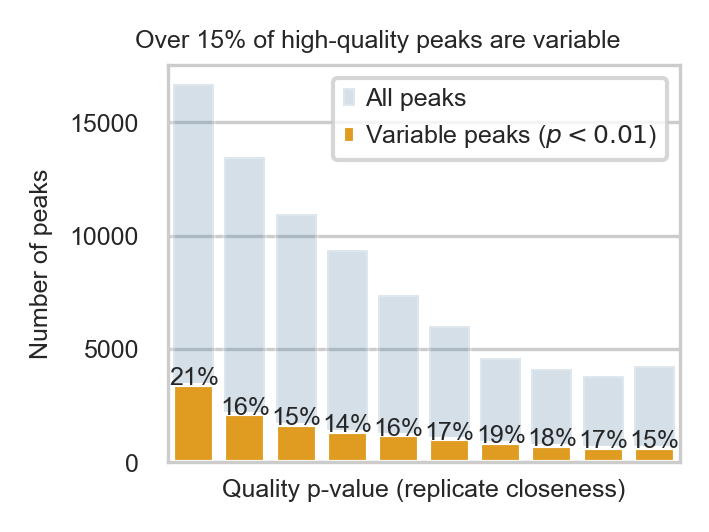

In [59]:
CQ_df = ATAC_data.var[['clonal_p','quality_p']]
qbins = np.arange(0,1.001,0.1)
qcuts = pd.cut(CQ_df.quality_p, qbins)
iindex = pd.IntervalIndex(qcuts.unique()) #.from_tuples([(x,x+1 - 1e-10) for x in np.arange(0,1,0.1)])
plot_df = pd.DataFrame(index = iindex)
plot_df['nsig'] = CQ_df.groupby(qcuts).apply(lambda x : (x < 0.01).sum()).clonal_p
plot_df['count'] = CQ_df.groupby(qcuts).count().clonal_p
plot_df['ratio'] = plot_df['nsig'] / plot_df['count']
plot_df['interval'] = plot_df.index#.apply(lambda x : x.left())
plot_df['mid'] = plot_df['interval'].apply(lambda x : x.mid)
plot_df = plot_df.sort_values(by='mid')

sns.set_style('whitegrid')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.barplot(x='mid', y='count', data=plot_df, color='steelblue', alpha=0.25, ax=ax, label='All peaks')
sns.barplot(x='mid', y='nsig', data=plot_df, color='orange', label='Variable peaks ($p<0.01$)',ax=ax)
#for row in plot_df:
#    ax.text(row['interval'], row['nsig'], 'Hello')
for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['nsig']
    ratioj = plot_df.iloc[j]['ratio']
    ax.text(j,nsigj,'{:1.0%}'.format(ratioj), ha='center')

ax.set_xticks([])
ax.set_xticklabels([]) #plot_df['interval'])
ax.legend()
plt.xticks(rotation=45)

ax.set_xlabel('Quality p-value (replicate closeness)')
ax.set_ylabel('Number of peaks')
plt.suptitle('Over 15% of high-quality peaks are variable')

set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

In [60]:
tall_peaks = (ATACR_data.to_df().max() > np.log1p(50))
tall_peaks = tall_peaks[tall_peaks].index
tall_peaks

Index(['Interval_13433', 'Interval_27763', 'Interval_4280', 'Interval_6501',
       'Interval_68580', 'Interval_72287', 'Interval_7590', 'Interval_38287',
       'Interval_49328', 'Interval_1833',
       ...
       'Interval_9823', 'Interval_63568', 'Interval_54425', 'Interval_33873',
       'Interval_2270', 'Interval_69022', 'Interval_56910', 'Interval_57434',
       'Interval_28417', 'Interval_8387'],
      dtype='object', name='PeakID', length=16370)

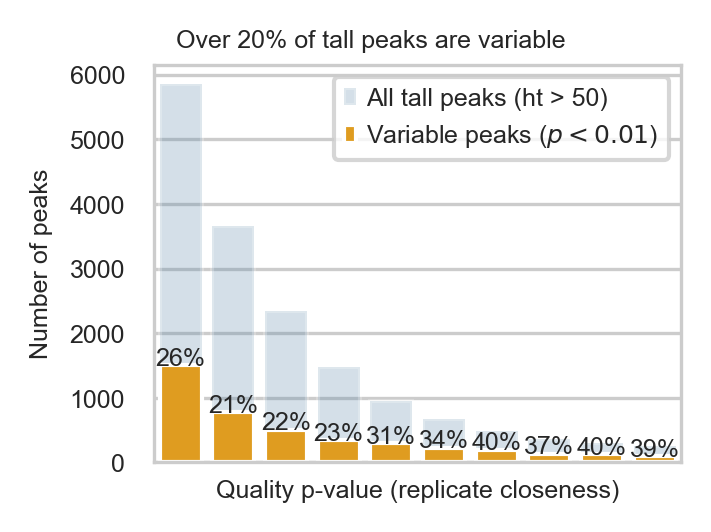

In [61]:
CQ_df = ATAC_data.var[['clonal_p','quality_p']]
CQ_df = CQ_df.loc[tall_peaks]
qbins = np.arange(0,1.001,0.1)
qcuts = pd.cut(CQ_df.quality_p, qbins)
iindex = pd.IntervalIndex(qcuts.unique()) #.from_tuples([(x,x+1 - 1e-10) for x in np.arange(0,1,0.1)])
plot_df = pd.DataFrame(index = iindex)
plot_df['nsig'] = CQ_df.groupby(qcuts).apply(lambda x : (x < 0.01).sum()).clonal_p
plot_df['count'] = CQ_df.groupby(qcuts).count().clonal_p
plot_df['ratio'] = plot_df['nsig'] / plot_df['count']
plot_df['interval'] = plot_df.index#.apply(lambda x : x.left())
plot_df['mid'] = plot_df['interval'].apply(lambda x : x.mid)
plot_df = plot_df.sort_values(by='mid')

sns.set_style('whitegrid')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.barplot(x='mid', y='count', data=plot_df, color='steelblue', alpha=0.25, ax=ax, label='All tall peaks (ht > 50)')
sns.barplot(x='mid', y='nsig', data=plot_df, color='orange', label='Variable peaks ($p<0.01$)',ax=ax)
#for row in plot_df:
#    ax.text(row['interval'], row['nsig'], 'Hello')
for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['nsig']
    ratioj = plot_df.iloc[j]['ratio']
    ax.text(j,nsigj,'{:1.0%}'.format(ratioj), ha='center')

ax.set_xticks([])
ax.set_xticklabels([]) #plot_df['interval'])
ax.legend()
plt.xticks(rotation=45)

ax.set_xlabel('Quality p-value (replicate closeness)')
ax.set_ylabel('Number of peaks')
plt.suptitle('Over 20% of tall peaks are variable')

set_size(fig, figsize)
plt.savefig("Panels/ClonalTall_peaks.pdf", bbox_inches='tight')
plt.show()

We consider the "good" peaks to be those with quality p-value > 0.1.  In other words, these are peaks whose intra-replicate distances are all below the 90th percentile.  

In [62]:
ATAC_good = ATAC_data[:,ATAC_data.var.quality_p > 0.1]

In [63]:
peak_look = ATAC_good.var.clonal_p.sort_values()[:1000].index

Here is a typical clonal high-quality peak.

In [64]:
ATAC_data.var.loc[peak_look].clonal_p.sort_values()[:10]

PeakID
Interval_32862    0.000504
Interval_38111    0.000504
Interval_28339    0.000504
Interval_63852    0.000504
Interval_21089    0.000504
Interval_39532    0.000504
Interval_74596    0.000504
Interval_60161    0.000504
Interval_38170    0.000504
Interval_53024    0.000504
Name: clonal_p, dtype: float64

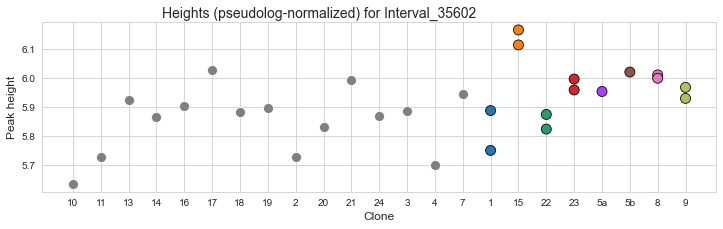

In [65]:
desetfontsize()
ATAC_plot('Interval_35602')

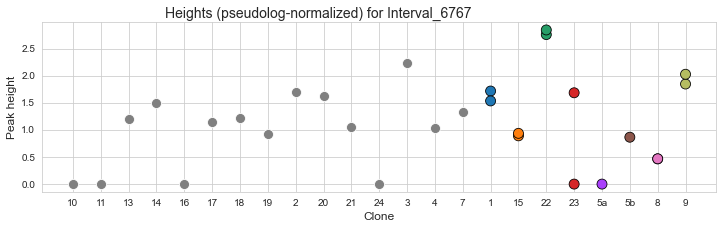

In [66]:
ATAC_plot('Interval_6767')

# Panel:  Peak heatmap

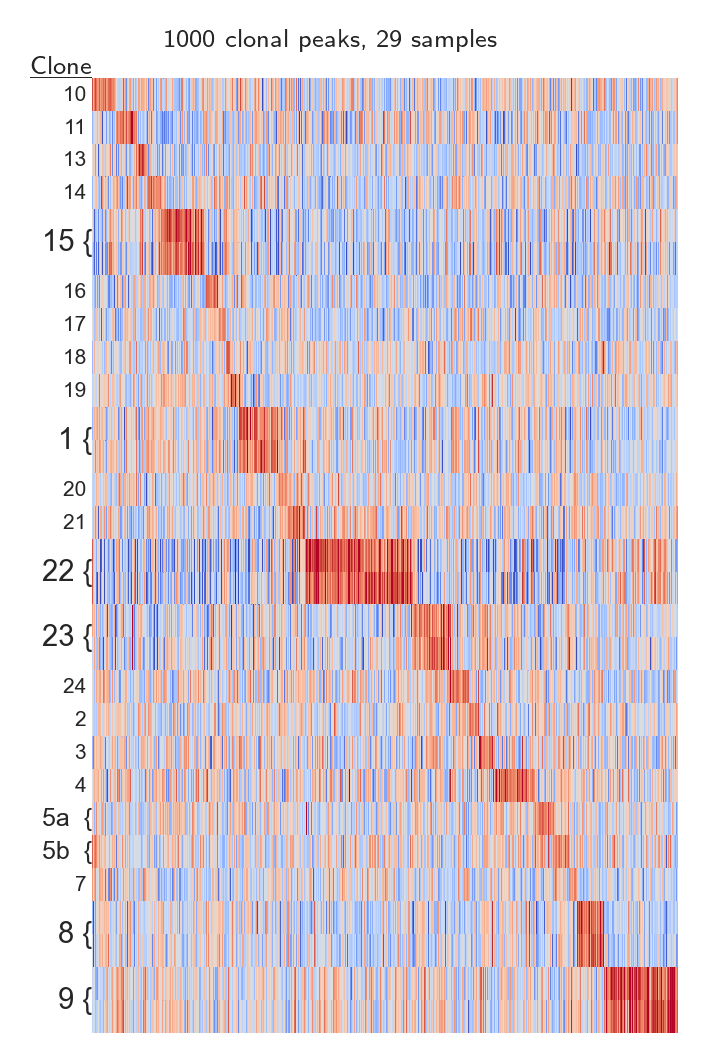

In [67]:
var_peaks = ATAC_good.var.clonal_p.sort_values()[:1000].index

plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 90*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-0.1,y,str(clone) + ' {', va='center', ha='right', fontsize=7)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=5)
    
ax.text(-0.1,22.5,'5a  {', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b  {', va='center', ha='right', fontsize = 6)

from matplotlib import rc

rc('text', usetex=True)

ax.text(-0.1,0,r'\underline{Clone}', va='bottom', ha='right', fontsize=6)
plt.suptitle('{} clonal peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakHeatmap.pdf", bbox_inches='tight')

plt.show()

# Peak-gene correlations

Now we create a giant correlation matrix -- one for each chromosome -- between gene expression (clonal average) and peak height (clonal average), for all genes and peaks on that chromosome.  We only use the "good clones" (16 out of 24 clones) found in preprocessing, when computing these correlations.  We also restrict to "good" peaks, where replicates have close peak heights.

In [68]:
genes = adata.var_names
genes

Index(['WASH7P', 'AL627309.1', 'RP11-34P13.13', 'MTND2P28', 'hsa-mir-6723',
       'RP5-857K21.7', 'MTATP8P1', 'MTATP6P1', 'RP5-857K21.11',
       'RP11-206L10.9',
       ...
       'VBP1-1', 'RAB39B-1', 'TMLHE-1', 'VAMP7', 'IL9R', 'EIF4A1P2', 'SRIP3',
       'AC010970.2', 'RNA5-8SP6', 'PSMA6P1'],
      dtype='object', name='gene_name', length=11881)

In [69]:
peaks = ATAC_good.var_names
peaks

Index(['Interval_77062', 'Interval_18293', 'Interval_48454', 'Interval_27763',
       'Interval_53540', 'Interval_46787', 'Interval_23335', 'Interval_40339',
       'Interval_76361', 'Interval_15915',
       ...
       'Interval_27261', 'Interval_76540', 'Interval_78442', 'Interval_57434',
       'Interval_58433', 'Interval_62113', 'Interval_45676', 'Interval_43639',
       'Interval_35777', 'Interval_10427'],
      dtype='object', name='PeakID', length=63909)

In [70]:
chromes = [str(j) for j in range(1,23)] + ['X','Y']
print(chromes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']


For each of the good clones, we create dataframes of the clonal averages for gene expression and peak height.

In [71]:
test_clones = adata.obs[adata.obs['Good clone'] == True].Clone_ID.unique()
test_clones = [clone for clone in test_clones if clone in ATAC_data.obs.Clone_ID.unique()]

pd_peak = ATAC_data[ATAC_data.obs['Clone_ID'].isin(test_clones)]
pd_gene = adata[adata.obs['Clone_ID'].isin(test_clones)]

gene_clonal = pd_gene.to_df().groupby(pd_gene.obs.Clone_ID).mean()
peak_clonal = pd_peak.to_df().groupby(pd_peak.obs.Clone_ID).mean()

In [72]:
gene_clonal

gene_name,WASH7P,AL627309.1,RP11-34P13.13,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP8P1,MTATP6P1,RP5-857K21.11,RP11-206L10.9,...,VBP1-1,RAB39B-1,TMLHE-1,VAMP7,IL9R,EIF4A1P2,SRIP3,AC010970.2,RNA5-8SP6,PSMA6P1
Clone_ID,,,,,,,,,,,,,,,,,,,,,
P1_A03,0.618283,0.945561,1.025549,3.235500,2.083895,0.750680,0.459195,5.755206,0.250811,0.000000,...,3.447827,0.000000,0.000000,0.000000,0.000000,0.000000,1.491540,6.902879,1.868600,0.802588
P1_A05,0.000000,0.000000,0.000000,2.712187,1.456248,0.407113,0.000000,5.386560,0.229657,0.000000,...,4.643641,0.000000,1.078488,2.631706,0.000000,0.135689,1.724590,6.760322,1.604085,0.302625
P1_A08,0.000000,0.000000,0.000000,3.053064,1.616868,0.697563,0.414321,5.804655,0.227296,0.000000,...,4.286690,0.000000,2.964008,0.000000,0.000000,0.000000,1.283545,6.123337,1.978948,0.000000
P1_A12,0.190624,0.000000,0.000000,3.038536,1.861662,0.000000,0.472903,5.478726,0.000000,0.888312,...,4.638396,0.864891,3.823669,2.864282,0.000000,0.230631,1.922047,6.479896,0.000000,0.199741
P1_B10,0.000000,0.000000,0.000000,3.115203,2.256257,0.699134,0.425098,5.694868,0.000000,0.000000,...,2.665425,0.772898,3.731382,2.401685,0.000000,0.325636,1.543150,6.618936,3.252234,0.182327
P1_C11,0.195251,0.000000,0.000000,2.748705,1.980835,0.540095,0.000000,5.840600,0.252954,0.000000,...,3.885841,0.892146,1.207822,2.805009,2.455279,0.105118,1.013093,6.190698,1.319050,0.000000
P1_D09,0.000000,0.000000,0.000000,2.579358,1.508479,0.527772,0.454545,5.743250,0.213638,0.949451,...,4.358072,0.686928,1.850092,2.886688,0.000000,0.248796,1.610327,6.392721,2.055962,0.000000
P1_F10,0.000000,0.000000,0.000000,2.925440,1.696129,0.626677,0.000000,5.868581,0.273484,0.000000,...,4.180732,0.902162,0.000000,1.396651,1.221312,0.000000,2.020712,6.250185,1.113877,0.000000
P1_H01,0.000000,0.000000,0.000000,3.109386,1.951495,0.371031,0.505814,5.827295,0.000000,0.000000,...,4.212268,0.000000,1.494714,1.758571,0.000000,0.138110,1.123212,6.057616,1.935471,0.426746


In [73]:
peak_clonal

PeakID,Interval_77062,Interval_18293,Interval_51938,Interval_33832,Interval_13433,Interval_48454,Interval_27763,Interval_53540,Interval_46169,Interval_46787,...,Interval_58433,Interval_62113,Interval_45676,Interval_43639,Interval_35777,Interval_8387,Interval_17712,Interval_31505,Interval_18056,Interval_10427
Clone_ID,,,,,,,,,,,,,,,,,,,,,
P1_A03,2.397638,0.396998,2.529633,2.150198,5.617923,1.967855,3.278499,3.233557,0.939784,0.000000,...,2.185111,2.035630,3.081982,0.561223,0.659377,4.251013,1.816327,1.216354,1.990757,0.324315
P1_A05,2.717578,2.192299,1.972389,2.088377,5.437860,0.633384,3.517708,2.451669,0.633384,0.000000,...,2.827997,2.088377,2.525063,1.018107,1.690073,3.377151,2.372459,1.295254,1.972389,0.633384
P1_A08,2.928915,0.000000,2.287843,1.691356,5.560565,2.287843,3.709698,3.762476,0.000000,0.000000,...,3.040741,1.167335,2.802991,0.000000,0.000000,3.465355,2.490481,0.000000,1.691356,0.000000
P1_A12,2.225148,1.634604,2.426444,2.426444,5.683740,1.119627,3.585825,3.326052,1.634604,0.000000,...,1.972849,2.426444,2.593931,1.119627,0.000000,4.235591,1.972849,0.000000,1.634604,1.634604
P1_B10,2.987230,2.205004,1.853198,2.670728,5.436592,2.205004,3.504991,3.114438,1.853198,0.000000,...,3.227275,1.853198,3.582720,1.305652,0.000000,4.223213,1.853198,2.205004,1.853198,0.000000
P1_C11,2.751107,0.571870,2.591159,1.970270,5.644123,1.856460,3.638525,3.083403,1.580603,1.407641,...,1.407641,1.407641,3.436934,1.407641,0.000000,3.461447,1.580603,1.580603,1.407641,0.000000
P1_D09,2.464640,1.027191,3.449496,2.299183,5.493403,3.114337,3.700081,3.607240,1.523099,0.000000,...,2.100815,1.523099,2.464640,1.853109,1.027191,3.031354,2.841349,1.853109,2.464640,0.000000
P1_F10,2.149178,0.000000,2.824024,2.065458,5.619921,1.974084,3.443976,3.507894,0.524072,0.000000,...,2.065458,1.491657,2.864107,0.000000,1.635758,4.014984,1.873513,1.323239,1.761685,0.000000
P1_H01,2.556990,0.624559,1.892109,2.524847,5.518234,1.727383,3.856328,3.475958,1.315365,0.233445,...,2.290025,1.509294,1.788409,0.759774,1.367123,4.081071,2.330552,1.482836,1.971055,0.000000


The following function creates the giant correlation matrix.

In [74]:
def pg_corr(chrome, method='pearson'):
    pd_peak = peak_clonal.loc[:,ATAC_data.var.chr == chrome]
    pd_gene = gene_clonal.loc[:,adata.var.chr == chrome]
    
    print('Making corr. matrix for chromosome {} with {} peaks and {} genes.'.format(
        chrome, pd_peak.shape[1], pd_gene.shape[1]))

    A = pd_peak
    E = pd_gene
    
    if method == 'spearman':
        A = A.rank()
        E = E.rank()
    Az = (A - A.mean())
    Ez = (E - E.mean())
    C = Az.T.dot(Ez).div(len(A)).div(Ez.std(ddof=0)).div(Az.std(ddof=0), axis=0)
    return C.sort_index()

It will take just a few seconds to make the correlation matrices for every chromosome.

In [75]:
pg_corrs = {}
for chrome in chromes:
    pg_corrs[chrome] = pg_corr(chrome).fillna(0)

Making corr. matrix for chromosome 1 with 7289 peaks and 1248 genes.
Making corr. matrix for chromosome 2 with 6684 peaks and 802 genes.
Making corr. matrix for chromosome 3 with 5425 peaks and 681 genes.
Making corr. matrix for chromosome 4 with 4310 peaks and 429 genes.
Making corr. matrix for chromosome 5 with 4407 peaks and 550 genes.
Making corr. matrix for chromosome 6 with 5201 peaks and 648 genes.
Making corr. matrix for chromosome 7 with 4297 peaks and 569 genes.
Making corr. matrix for chromosome 8 with 3449 peaks and 380 genes.
Making corr. matrix for chromosome 9 with 3257 peaks and 465 genes.
Making corr. matrix for chromosome 10 with 3640 peaks and 460 genes.
Making corr. matrix for chromosome 11 with 3888 peaks and 627 genes.
Making corr. matrix for chromosome 12 with 3987 peaks and 666 genes.
Making corr. matrix for chromosome 13 with 2159 peaks and 210 genes.
Making corr. matrix for chromosome 14 with 2512 peaks and 388 genes.
Making corr. matrix for chromosome 15 with

# Looking at correlations within windows.

We look at peaks within a window around each gene.  For a close-up look, we consider peaks within 50kb upstream of the TSS, together with the region between the gene start and end sites.  (We add a little 5kb wiggle-room too.)  For a broader look, we look at peaks within 500kb of the TSS.  The following function finds the peaks within such windows around a given gene.

In [76]:
def peaks_near(gene, window=50000, tol = 5000.0, method='TSSUp'):
    gene_chrome = adata.var.chr[gene]
    gene_TSS = adata.var.TSS[gene]
    gene_start = adata.var.start[gene]
    gene_end = adata.var.end[gene]
    gene_dir = adata.var.dir[gene]

    p_df = ATAC_good.var[ATAC_good.var.chr == gene_chrome]
    dist_peak_TSS = gene_dir * (gene_TSS - p_df.mid)
    if method == 'TSSCenter':
        p_range = abs(dist_peak_TSS) < window
    elif method == 'TSSUp':
        up_range = (dist_peak_TSS < window) & (dist_peak_TSS >= -tol)
        in_range = (p_df.mid > gene_start - tol) & (p_df.mid < gene_end + tol)
        p_range = up_range | in_range
    else:
        print('Method unknown.')
        return None
    p_df = p_df[p_range]
    return p_df.index

The following function adds up the coefficients of determination for all peaks within a window around a gene. 

In [77]:
def total_corr_near(gene, window=500000):
    pn = peaks_near(gene, window, method='TSSCenter')
    gene_chrome = adata.var.chr[gene]
    R_sq_list = pg_corrs[gene_chrome][gene][pn]**2
    loc_list = ATAC_good.var.loc[pn].mid - adata.var.TSS[gene]
    tcn_df = pd.DataFrame(index=pn)
    tcn_df['R_sq'] = R_sq_list
    tcn_df['relative_loc'] = loc_list
    tcn_df['loc_bin'] = pd.cut(loc_list, bins=np.arange(-500000,500001,5000))
    return tcn_df.groupby('loc_bin')['R_sq'].sum()

In [78]:
tcn = total_corr_near('GNLY')
tcn

loc_bin
(-500000, -495000]    0.041686
(-495000, -490000]    0.000000
(-490000, -485000]    0.000000
(-485000, -480000]    0.000000
(-480000, -475000]    0.000000
                        ...   
(475000, 480000]      0.000000
(480000, 485000]      0.000000
(485000, 490000]      0.000000
(490000, 495000]      0.000000
(495000, 500000]      0.000000
Name: R_sq, Length: 200, dtype: float32

We add up the peak-correlations within a 500000bp window around every gene.  This will take a minute or two.

In [79]:
TSS_intervals = tcn.index
genes_chrome = [gene for gene in genes if adata.var.chr[gene] in chromes]

TSS_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)
TSS_plot

for j,gene in enumerate(genes_chrome):
    if j%1000 == 0:
        print('{} genes complete'.format(j))
    TSS_plot[gene] = total_corr_near(gene)

0 genes complete
1000 genes complete
2000 genes complete
3000 genes complete
4000 genes complete
5000 genes complete
6000 genes complete
7000 genes complete
8000 genes complete
9000 genes complete
10000 genes complete
11000 genes complete


## Panel:  Total R^2 for peak~gene within 500kb of TSS.

In [80]:
plot_df = pd.DataFrame(TSS_plot.sum(axis=1), columns=['Total R^2'])
plot_df['x'] = np.arange(-500000,500000, 5000) + 2500
plot_df.head()

,Total R^2,x
loc_bin,,
"(-500000, -495000]",132.924057,-497500
"(-495000, -490000]",133.605408,-492500
"(-490000, -485000]",137.357162,-487500
"(-485000, -480000]",137.347290,-482500
"(-480000, -475000]",134.227310,-477500


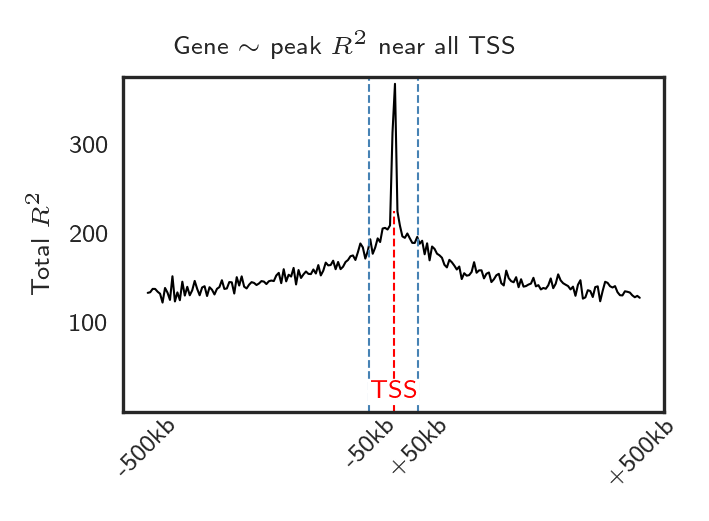

In [82]:

sns.set_style('white')
figsize=(60*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.lineplot(x='x', y='Total R^2', data=plot_df,  color='k', linewidth=0.5, ax=ax)

ax.set_ylim(0,375)
ax.axvline(0,color='red', linestyle='--', ymax=0.6, linewidth=0.5)
ax.set_xticks([-500000,-50000,50000,500000])
ax.set_xticklabels(['-500kb','-50kb','+50kb','+500kb'], rotation=45, y=0.08)
ax.set_yticks([100,200,300])
ax.set_yticklabels([100,200,300], x=0.03)
ax.text(0,15,'TSS',color='red', ha='center', bbox={'facecolor':'white',  'pad':0})
ax.axvline(50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.axvline(-50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.set_xlabel('')
ax.set_ylabel('Total $R^2$')
set_size(fig, figsize)
plt.savefig("Panels/R2_near_TSS.pdf", bbox_inches='tight')
plt.suptitle('Gene $\sim$ peak $R^2$ near all TSS', y=1.02)
plt.show()

# Peak gene correlations, close to each gene

We perform principal component regression to study the effect of peak heights (all peaks within a window) on gene expression.  Our window includes the whole start-end length of the gene, plus 50kb upstream of the TSS.


In [83]:
promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].unique()
num_promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].nunique()

In [84]:
def peak_corrmatrix(peaklist):
    pc_df = peak_clonal[peaklist]
    return pc_df.corr()

In [85]:
def PCR_analysis(gene, peaklist=None, window=50000, theta = 0.05, verbose=False):
    if not peaklist:
        peaklist = peaks_near(gene, window=window)
    else:
        peaklist = peaklist
        
    out_df = pd.DataFrame(np.eye(len(peaklist)), index = peaklist, columns = peaklist)
    
    
    chrome = adata.var.chr[gene]
    corr_with_gene = pg_corrs[chrome][gene][peaklist]
    #display(corr_with_gene**2)
    max_peaks = max(0,len(peak_clonal) - 1) # Cannot use too many peaks!
    cwg = corr_with_gene.sort_values(ascending=False)[:max_peaks] 
    sel_peaks = cwg[cwg**2 > theta].index
    
    #print(sel_peaks)
    out_df = out_df.loc[sel_peaks]
    
    # display(out_df)
    
    peak_corrs = peak_corrmatrix(sel_peaks)
    
    #display(peak_corrs)
    #display(corr_with_gene**2)
    C = peak_corrs
    #C = C.multiply(corr_with_gene)
    #C = C.multiply(corr_with_gene, axis=0)
    eigens = np.linalg.eigh(C) #[0]
    #display(C)
    evals = eigens[0]
    evecs = eigens[1]
    #print(evecs)
    realpeaks = peak_clonal[sel_peaks]
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    #display(normpeaks)
    eigenpeaks = pd.DataFrame(np.dot(normpeaks, evecs), index=normpeaks.index)
    eig_cols = ['Eigenpeak {}'.format(str(j)) for j in range(len(sel_peaks))]
    out_df[eig_cols] = evecs
    eigenpeaks.columns = eig_cols
    if verbose: 
        display(eigenpeaks)
        display(eigenpeaks.corr())
    out_df.loc['{}_R'.format(gene), peaklist] = corr_with_gene
    out_df.loc['{}_Rsq'.format(gene), peaklist] = corr_with_gene**2
    
    gene_ensg = adata.var.loc[gene].ENSG
    if gene_ensg in promoters.index:
        prom_list = promoters[gene_ensg]
    else:
        prom_list = []
        
    out_df.loc[gene+'_promoter', peaklist] = peaklist.isin(prom_list)
    #print(peaklist.isin(prom_list))
    #display(out_df)
    
    out_df.loc['{}_R'.format(gene), eig_cols] = (eigenpeaks).corrwith(gene_clonal[gene])
    out_df.loc['{}_Rsq'.format(gene), eig_cols] = out_df.loc['{}_R'.format(gene), eig_cols]**2
    
    #insig_eigs = (out_df.loc['{}_Rsq'.format(gene), eig_cols] < 2*theta)
    #insig_eigs = insig_eigs[insig_eigs].index
    #print(insig_eigs)
    #out_df.drop(columns=insig_eigs, inplace=True)
    #display(out_df)
    return out_df

We carry out a brief analysis of all (non-mito) genes here.  It will take a minute or two.

In [86]:
PCR_ans = {}
for j,gene in enumerate(adata.var_names.unique()):
    if j == 100:
        print('100 genes complete')
    if j%500 == 0:
        print('{} genes completed'.format(j))
    if adata.var.chr[gene] != 'MT': # No Mito genes in ATAC data.
        PCR_ans[gene] = PCR_analysis(gene)

0 genes completed
100 genes complete
500 genes completed
1000 genes completed
1500 genes completed
2000 genes completed
2500 genes completed
3000 genes completed
3500 genes completed
4000 genes completed
4500 genes completed
5000 genes completed
5500 genes completed
6000 genes completed
6500 genes completed
7000 genes completed
7500 genes completed
8000 genes completed
8500 genes completed
9000 genes completed
9500 genes completed
10000 genes completed
10500 genes completed
11000 genes completed
11500 genes completed


In [87]:
PCR_ans['GNLY']

PeakID,Interval_38954,Interval_38953,Interval_38958,Interval_38960,Interval_38952,Interval_38956,Interval_38957,Interval_38955,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4,Eigenpeak 5
PeakID,,,,,,,,,,,,,,
Interval_38960,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.649201,0.319882,0.436807,0.074543,-0.051089,-0.526542
Interval_38958,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.037467,0.247217,-0.705323,0.480680,-0.238539,-0.389931
Interval_38952,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.225503,-0.311749,-0.413907,-0.742980,-0.051701,-0.354893
Interval_38957,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.330066,-0.434762,0.335812,0.092549,-0.695269,-0.311937
Interval_38956,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.037681,-0.634704,0.018647,0.382499,0.585323,-0.326306
Interval_38954,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.644918,-0.384063,-0.165180,0.237697,-0.334387,0.490895
GNLY_R,-0.478716,0.099327,0.517197,0.793927,0.50086,0.276469,0.459019,0.088697,-0.348087,0.050861,0.017245,-0.031298,-0.174513,-0.771071
GNLY_Rsq,0.229169,0.009866,0.267493,0.63032,0.250861,0.076435,0.210699,0.007867,0.121164,0.002587,0.000297,0.000980,0.030455,0.594551
GNLY_promoter,False,False,False,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


We can hunt for *repressor* peaks by looking for very negative R values as below.

In [88]:
for gene in PCR_ans.keys():
    PCR_df = PCR_ans[gene]
    int_cols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    R_vals = PCR_df.loc[gene+'_R', int_cols]
    if R_vals.min() < -0.8:
        display(PCR_df)

PeakID,Interval_7914,Interval_7912,Interval_7915,Interval_7916,Interval_7910,Eigenpeak 0,Eigenpeak 1
PeakID,,,,,,,
Interval_7914,1.0,0.0,0.0,0.0,0.0,-0.707107,-0.707107
Interval_7915,0.0,0.0,1.0,0.0,0.0,-0.707107,0.707107
PTPLA_R,0.414435,0.167362,-0.824415,-0.107373,-0.04491,0.415283,-0.712245
PTPLA_Rsq,0.171756,0.02801,0.67966,0.011529,0.002017,0.172460,0.507292
PTPLA_promoter,False,False,False,False,False,NaN,NaN


PeakID,Interval_12707,Interval_12708,Interval_12706,Eigenpeak 0,Eigenpeak 1
PeakID,,,,,
Interval_12706,0.0,0.0,1.0,-0.707107,0.707107
Interval_12707,1.0,0.0,0.0,0.707107,0.707107
POLA2_R,-0.832008,-0.010158,-0.30152,-0.417184,-0.734286
POLA2_Rsq,0.692237,0.000103,0.090914,0.174043,0.539176
POLA2_promoter,False,True,False,NaN,NaN


PeakID,Interval_28631,Interval_28630,Interval_28633,Interval_28632,Interval_28636,Interval_28634,Interval_28635,Interval_28629,Interval_28628,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4,Eigenpeak 5
PeakID,,,,,,,,,,,,,,,
Interval_28629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.171204,0.458659,-0.265992,0.678584,0.397227,-0.267028
Interval_28630,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.229430,0.288613,0.531537,-0.273252,0.694289,0.157573
Interval_28634,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.335186,0.434567,0.398577,0.387441,-0.521862,0.342765
Interval_28633,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.182545,-0.659626,0.057835,0.519632,0.277506,0.425676
Interval_28635,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.384583,0.251296,-0.693749,-0.207122,0.103673,0.503994
Interval_28628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.790237,0.138675,0.056743,-0.042776,0.008720,0.592595
WDR81_R,0.211021,-0.281517,-0.39769,0.084281,-0.213297,-0.360108,-0.692189,0.355854,-0.829867,0.192515,-0.185262,0.031259,0.146408,-0.046731,-0.792307
WDR81_Rsq,0.04453,0.079252,0.158157,0.007103,0.045496,0.129677,0.479125,0.126632,0.688678,0.037062,0.034322,0.000977,0.021435,0.002184,0.627750
WDR81_promoter,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_31680,Interval_31679,Interval_31675,Interval_31677,Interval_31678,Eigenpeak 0
PeakID,,,,,,
Interval_31677,0.0,0.0,0.0,1.0,0.0,1.00000
TNRC6C_R,0.164693,-0.091602,-0.197118,-0.82714,-0.136104,-0.82714
TNRC6C_Rsq,0.027124,0.008391,0.038855,0.68416,0.018524,0.68416
TNRC6C_promoter,False,False,False,False,True,NaN


PeakID,Interval_34572,Interval_34574,Interval_34569,Interval_34567,Interval_34566,Interval_34568,Interval_34577,Interval_34565,Interval_34570,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4,Eigenpeak 5
PeakID,,,,,,,,,,,,,,,
Interval_34567,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.036138,-0.237097,0.343555,-0.793847,-0.325860,-0.296769
Interval_34569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.442847,-0.086588,-0.538722,0.147835,-0.611262,-0.332673
Interval_34572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.193282,0.641365,0.423904,0.288386,-0.288039,-0.453283
Interval_34565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.654904,0.228392,0.041701,-0.170380,0.577882,-0.392711
Interval_34574,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.576956,0.062438,-0.561124,-0.172969,0.289491,-0.484396
Interval_34566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.058694,-0.684746,0.308957,0.453694,0.139481,-0.454895
RNASEH2A_R,-0.550169,-0.623425,-0.292098,-0.284012,-0.804227,-0.057409,0.155131,-0.56181,0.190978,0.069978,0.209717,-0.144635,-0.149954,-0.161315,0.777317
RNASEH2A_Rsq,0.302686,0.388658,0.085321,0.080663,0.646781,0.003296,0.024066,0.315631,0.036473,0.004897,0.043981,0.020919,0.022486,0.026022,0.604222
RNASEH2A_promoter,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_34644,Interval_34647,Interval_34641,Interval_34648,Interval_34643,Interval_34640,Interval_34642,Interval_34646,Eigenpeak 0,Eigenpeak 1
PeakID,,,,,,,,,,
Interval_34641,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.707107,0.707107
Interval_34642,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.707107,0.707107
ZSWIM4_R,-0.159354,-0.096856,-0.555371,0.007067,-0.175304,0.217909,-0.807004,0.063407,-0.248750,-0.789642
ZSWIM4_Rsq,0.025394,0.009381,0.308436,0.00005,0.030732,0.047484,0.651255,0.00402,0.061877,0.623534
ZSWIM4_promoter,False,False,False,False,False,False,False,False,NaN,NaN


PeakID,Interval_35840,Interval_35820,Interval_35823,Interval_35822,Interval_35835,Interval_35827,Interval_35818,Interval_35817,Interval_35829,Interval_35821,...,Interval_35836,Interval_35830,Interval_35831,Interval_35834,Interval_35824,Interval_35828,Interval_35837,Interval_35839,Eigenpeak 0,Eigenpeak 1
PeakID,,,,,,,,,,,,,,,,,,,,,
Interval_35826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.707107,0.707107
Interval_35832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.707107
MARK4_R,0.062365,0.009838,-0.848172,-0.055361,-0.464867,-0.157907,-0.243045,0.001945,-0.326618,-0.174052,...,-0.034096,-0.263781,-0.270783,-0.204832,-0.512891,-0.202013,-0.044096,-0.020382,-0.361588,0.008554
MARK4_Rsq,0.003889,0.000097,0.719396,0.003065,0.216101,0.024935,0.059071,0.000004,0.106679,0.030294,...,0.001163,0.069581,0.073323,0.041956,0.263057,0.040809,0.001944,0.000415,0.130746,0.000073
MARK4_promoter,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,NaN,NaN


PeakID,Interval_35870,Interval_35878,Interval_35872,Interval_35880,Interval_35871,Interval_35879,Interval_35873,Interval_35869,Interval_35874,Interval_35875,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,,,,,,
Interval_35871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.528200,0.167217,0.039205,0.752104,-0.354747
Interval_35878,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.195303,-0.216130,0.903591,-0.009972,-0.313955
Interval_35872,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.260821,-0.703140,-0.401249,0.118780,-0.512305
Interval_35874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.473638,0.656427,-0.142473,-0.072382,-0.565006
Interval_35869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.624900,-0.004832,-0.026195,-0.644121,-0.440338
EML2_R,0.195169,-0.225418,-0.339943,-0.117802,0.234278,0.090075,-0.017614,-0.825912,-0.379751,-0.100648,-0.181194,0.126359,0.018520,0.657724,0.482080
EML2_Rsq,0.038091,0.050813,0.115561,0.013877,0.054886,0.008114,0.00031,0.682131,0.144211,0.01013,0.032831,0.015967,0.000343,0.432601,0.232401
EML2_promoter,False,False,True,False,True,False,True,False,False,True,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_46380,Interval_46377,Interval_46379,Interval_46378,Interval_46381,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2
PeakID,,,,,,,,
Interval_46381,0.0,0.0,0.0,0.0,1.0,0.020265,-0.930805,-0.364953
Interval_46380,1.0,0.0,0.0,0.0,0.0,-0.710271,0.243497,-0.660473
Interval_46379,0.0,0.0,1.0,0.0,0.0,0.703636,0.272600,-0.656190
THAP7-AS1_R,-0.70981,0.04764,-0.833162,-0.132839,-0.290844,-0.134563,-0.136507,0.866363
THAP7-AS1_Rsq,0.50383,0.00227,0.694158,0.017646,0.08459,0.018107,0.018634,0.750585
THAP7-AS1_promoter,True,False,False,False,False,NaN,NaN,NaN


PeakID,Interval_48815,Interval_48811,Interval_48810,Interval_48816,Interval_48814,Interval_48813,Interval_48809,Interval_48812,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2
PeakID,,,,,,,,,,,
Interval_48812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.735659,0.206526,-0.645100
Interval_48810,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.659016,0.438331,-0.611198
Interval_48814,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.156539,0.874764,0.458566
CX3CR1_R,-0.146545,-0.073746,0.272845,-0.13615,-0.84793,0.072962,-0.220777,0.502327,-0.082997,-0.571394,-0.673613
CX3CR1_Rsq,0.021475,0.005438,0.074444,0.018537,0.718986,0.005323,0.048742,0.252333,0.006889,0.326491,0.453755
CX3CR1_promoter,False,False,False,False,False,False,False,True,NaN,NaN,NaN


PeakID,Interval_49196,Interval_49194,Interval_49192,Interval_49197,Interval_49193,Interval_49191,Eigenpeak 0,Eigenpeak 1
PeakID,,,,,,,,
Interval_49196,1.0,0.0,0.0,0.0,0.0,0.0,-0.707107,0.707107
Interval_49197,0.0,0.0,0.0,1.0,0.0,0.0,0.707107,0.707107
DHX30_R,0.232945,-0.062689,0.147127,-0.804288,-0.060495,-0.163753,-0.804256,-0.373760
DHX30_Rsq,0.054264,0.00393,0.021646,0.646879,0.00366,0.026815,0.646828,0.139697
DHX30_promoter,False,False,False,False,True,False,NaN,NaN


PeakID,Interval_50636,Interval_50646,Interval_50642,Interval_50641,Interval_50644,Interval_50639,Interval_50638,Interval_50649,Interval_50643,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,,,,,
Interval_50646,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064360,0.766872,-0.244797,0.339253,-0.482439
Interval_50644,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.609542,-0.165451,-0.307274,-0.569877,-0.426505
Interval_50636,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.039170,-0.077353,-0.890044,0.143093,0.424062
Interval_50639,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.229679,0.567817,0.023851,-0.699016,0.368292
Interval_50643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.755003,0.236926,0.230022,0.225940,0.519498
PHLDB2_R,-0.467084,0.623617,-0.035791,0.200649,0.560877,-0.484676,-0.047488,0.085494,-0.822058,-0.214463,-0.083320,-0.141645,-0.021583,-0.806268
PHLDB2_Rsq,0.218167,0.388898,0.001281,0.04026,0.314583,0.234911,0.002255,0.007309,0.67578,0.045994,0.006942,0.020063,0.000466,0.650068
PHLDB2_promoter,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_62659,Interval_62655,Interval_62672,Interval_62656,Interval_62674,Interval_62675,Interval_62661,Interval_62671,Interval_62657,Interval_62663,...,Interval_62680,Interval_62676,Interval_62678,Interval_62679,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4,Eigenpeak 5
PeakID,,,,,,,,,,,,,,,,,,,,,
Interval_62671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.382206,0.366269,0.108898,-0.193444,-0.772613,-0.271212
Interval_62668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.507081,0.638341,-0.034938,0.130182,0.199180,-0.526829
Interval_62663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.067430,-0.204399,-0.571452,-0.730330,0.076152,-0.296539
Interval_62658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.387912,-0.617260,0.035258,0.321552,-0.402266,-0.449508
Interval_62677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.113173,-0.172486,0.768639,-0.389649,0.303173,-0.350563
Interval_62669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.654948,-0.076348,-0.261370,0.396267,0.322282,-0.485806
FAM65B_R,-0.109015,-0.153073,0.142392,-0.082905,-0.424297,-0.140013,0.075671,0.452342,-0.047006,0.318944,...,-0.84397,-0.372134,-0.277167,-0.445709,0.004413,0.271128,-0.024230,-0.181451,-0.181565,-0.460778
FAM65B_Rsq,0.011884,0.023431,0.020276,0.006873,0.180028,0.019604,0.005726,0.204613,0.00221,0.101725,...,0.712285,0.138483,0.076822,0.198657,0.000019,0.073510,0.000587,0.032925,0.032966,0.212316
FAM65B_promoter,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_63905,Interval_63900,Interval_63908,Interval_63901,Interval_63904,Interval_63906,Interval_63899,Interval_63907,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,,,,
Interval_63901,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.054611,-0.697250,-0.277057,-0.476678,-0.454838
Interval_63904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.366790,0.379933,0.506878,-0.664412,-0.150826
Interval_63907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.064720,-0.448504,0.766189,0.409253,-0.200304
Interval_63905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.637302,-0.238712,0.272951,-0.404217,0.546780
Interval_63906,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.672413,-0.333698,-0.069039,-0.021362,0.656722
PAQR8_R,-0.386708,-0.171704,0.172362,0.366373,0.306026,-0.904939,-0.157974,0.294247,-0.336263,0.166089,0.232729,-0.072473,-0.813968
PAQR8_Rsq,0.149543,0.029482,0.029709,0.134229,0.093652,0.818914,0.024956,0.086581,0.113073,0.027585,0.054163,0.005252,0.662544
PAQR8_promoter,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


PeakID,Interval_69616,Interval_69611,Interval_69615,Interval_69613,Interval_69617,Interval_69614,Interval_69609,Interval_69618,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2
PeakID,,,,,,,,,,,
Interval_69614,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.547623,0.627741,-0.553218
Interval_69613,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.428161,0.778284,0.459295
Interval_69611,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.718879,-0.014654,0.694981
PMS2P1_R,-0.119458,-0.80737,0.161394,-0.266771,0.099508,0.36348,-0.031862,0.012143,-0.420483,0.033076,-0.691239
PMS2P1_Rsq,0.01427,0.651846,0.026048,0.071167,0.009902,0.132118,0.001015,0.000147,0.176806,0.001094,0.477812
PMS2P1_promoter,False,False,False,False,False,False,False,False,NaN,NaN,NaN


## Panel:  Principal Component Regression -- summary.

We create a dataframe summarizing our PCR analysis, and make a plot of the peaks found.

In [89]:
PCR_summary = pd.DataFrame(index = PCR_ans.keys(), 
                           columns=['promoter_R_sq', 'num_eig'])

i = 0
for gene in PCR_ans.keys():
    i += 1
    if i%1000 == 0:
        print('{} genes processed.'.format(i))
    PCR_df = PCR_ans[gene]
    
    intcols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    PCR_summary.loc[gene,'num_peaks'] = len(intcols)
    
    eigencols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    promcols = (PCR_df.loc[gene+'_promoter'] == True)
    promcols = promcols[promcols].index
    #print(promcols)
    if len(promcols) > 0:
        #print(PCR_df.loc[gene+'_Rsq',promcols].max())
        PCR_summary.loc[gene, 'promoter_R_sq'] = PCR_df.loc[gene+'_Rsq',promcols].max()
    else:
        PCR_summary.loc[gene, 'promoter_R_sq'] = 0
    R2_int = PCR_df.loc[gene+'_Rsq',intcols]
    PCR_summary.loc[gene, 'num_sigpeaks'] = (R2_int > 0.2).sum()
    if len(eigencols) > 0:
        R2_eig = PCR_df.loc[gene+'_Rsq',eigencols]
        num_eig = (R2_eig > 0.2).sum()
        PCR_summary.loc[gene,'num_eig'] = num_eig
        eig_R_sq = R2_eig.sort_values(ascending=False)
        for j in range(len(eigencols)):
            PCR_summary.loc[gene, 'eigen{}_R_sq'.format(j)] = eig_R_sq[j]
    else:
        PCR_summary.loc[gene,'num_eig'] = 0
    #print(PCR_summary.loc[gene])

1000 genes processed.
2000 genes processed.
3000 genes processed.
4000 genes processed.
5000 genes processed.
6000 genes processed.
7000 genes processed.
8000 genes processed.
9000 genes processed.
10000 genes processed.
11000 genes processed.


In [90]:
PCR_summary

,promoter_R_sq,num_eig,num_peaks,num_sigpeaks,eigen0_R_sq,eigen1_R_sq,eigen2_R_sq,eigen3_R_sq,eigen4_R_sq,eigen5_R_sq,eigen6_R_sq,eigen7_R_sq,eigen8_R_sq,eigen9_R_sq,eigen10_R_sq,eigen11_R_sq,eigen12_R_sq,eigen13_R_sq,eigen14_R_sq
WASH7P,0,0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL627309.1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RP11-34P13.13,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTND2P28,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hsa-mir-6723,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EIF4A1P2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRIP3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC010970.2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RNA5-8SP6,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
plot_genes = adata.var.index

In [96]:
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

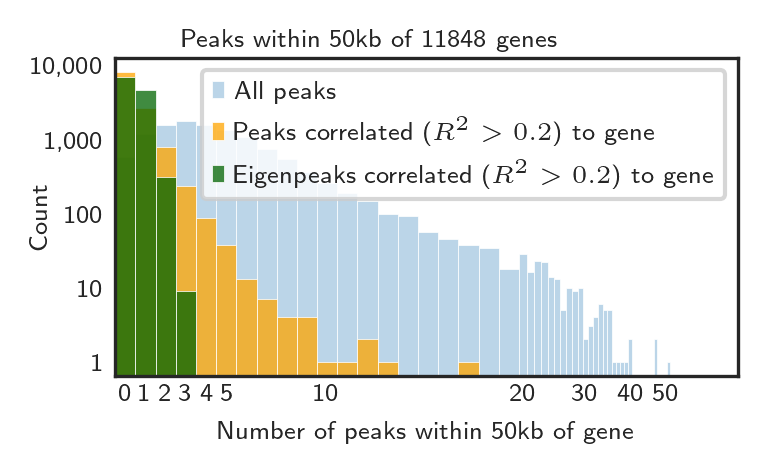

In [98]:
sns.set_style('white')
figsize=(65*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

bins=np.arange(0,75,1)
sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, ax=ax, alpha=0.3, label='All peaks')
sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, ax=ax, color='orange', label='Peaks correlated ($R^2 > 0.2$) to gene')
sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, ax=ax, color='darkgreen', label='Eigenpeaks correlated ($R^2 > 0.2$) to gene')
ax.legend()
plt.yscale('log')
plt.xscale('symlog',linthresh=20.0)
xt = [0,1,2,3,4,5,10,20,30,40,50]
ax.set_xticks([x + 0.5 for x in xt])
ax.set_xticklabels([0,1,2,3,4,5,10,20,30,40,50], y=0.07)
ax.set_yticks([1,10,100,1000,10000])
ax.set_yticklabels(['1','10','100','1,000','10,000'], x=0.03)
ax.set_xlim(0,80)
ax.set_xlabel('Number of peaks within 50kb of gene')
ax.set_ylabel('Count', labelpad=-5)
plt.suptitle('Peaks within 50kb of {} genes'.format(len(PCR_summary.loc[plot_genes])))

set_size(fig, figsize)
plt.savefig("Panels/PCR_Peaks.pdf", bbox_inches='tight')
plt.show()

# Multiomics plots

In [99]:
pg_clones = list(peak_clonal.index)
pg_clones

['P1_A03',
 'P1_A05',
 'P1_A08',
 'P1_A12',
 'P1_B10',
 'P1_C11',
 'P1_D09',
 'P1_F10',
 'P1_H01',
 'P1_H10',
 'P2_A04',
 'P2_B11',
 'P2_G01',
 'P2_G09',
 'P2_H04',
 'P2_H05']

In [100]:
prot_clonal = prot_data.to_df().groupby(prot_data.obs.Clone_ID).mean()
prot_clonal = prot_clonal.loc[pg_clones]
prot_clonal

var_names,CD57 FITC,A2 YF DEXTRA APC,CD8 A7,CD62L BV670,PD1 BV711,CD27 BV786,CD94 PE,CD3 PC5
Clone_ID,,,,,,,,
P1_A03,902.903320,27506.250000,8444.175781,-208.290939,1376.424927,-97.778107,2359.556641,2292.757568
P1_A05,803.705139,19328.957031,7142.438965,-32.177135,903.623413,-68.900253,393.199371,2615.705322
P1_A08,576.234619,19552.335938,7188.782227,-37.302555,1303.275879,-41.017300,7642.252441,2269.702393
P1_A12,413.486084,15468.637695,4991.385742,-77.271622,994.417175,-49.785648,279.779022,1625.113037
P1_B10,42.948910,14563.261719,8508.237305,-55.116821,2128.482666,22.142307,1226.074707,2014.063965
P1_C11,1643.779175,23151.318359,10985.375000,-18.524429,1235.683594,-62.457111,2831.641602,2888.821533
P1_D09,1441.065430,17640.460938,6325.950684,567.863037,2455.682129,-83.398872,60.759659,2319.213623
P1_F10,203.625443,16097.100586,7561.971680,-58.249008,1241.386597,-57.741810,1476.108765,1676.395996
P1_H01,1690.622925,14977.458984,6277.771973,4.625610,1099.460083,-65.979813,1879.674072,1961.431641


In [103]:
from matplotlib.ticker import FormatStrFormatter

def pgplot(gene, protein = None, cutoff=0.2, window=50000):
    sns.set_style('white')
    if protein:
        num_rows = 3
        hr = [2,1,1]
    else:
        num_rows = 2
        hr=[2,1]
        
    figsize=(60*mm,15*mm*num_rows)
    fig, ax = plt.subplots(num_rows,1,figsize=figsize, dpi=300, sharex=True,
                           gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    
    plt.rcParams['text.usetex'] = False
    setfontsize()

    PCR_df = PCR_analysis(gene, window=window)
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    
    
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
    clone_order = [clone for clone in clone_order if clone in pg_clones]
        
    for clone in clone_order:
        for row in range(num_rows):
            ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    
    sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
    gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
    ax[0].set_yticks(gene_ticks)
    ax[0].set_yticklabels(gene_ticks, x=0.03)
    ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[0].set_ylabel(gene)
    ax[0].yaxis.set_label_position("right")
    
    # ATAC PLOT
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
    pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        sns.lineplot(x='Clone', y=peak, data=pplot_df, ax=ax[-1], linewidth=0.7,
                    label=peak_label, alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int)) #, label=peak, legend=False)
    
    ax[-1].set_ylabel('Peak')
    ax[-1].yaxis.set_label_position("right")
    ax[-1].set_yticks([])
    ax[-1].set_xlabel('')
    
    # PROTEIN PLOT
    if protein:
        proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
        proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
        proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
        proplot_df['Clone'] = proplot_df.index
        sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
        ax[1].text(1,0.5,protein, ha='left')
        ax[1].set_ylabel('Prot')
        ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
    
    # General formatting.
    ax[0].spines['bottom'].set_color('lightgray')
    ax[-1].spines['top'].set_color('lightgray')
    
    plt.xticks(rotation=45)
    plt.xticks([])
    
    if protein:
        title = '{}, {}, and {} peaks.'.format(gene, protein, len(peaklist))
    else:
        title = '{} and {} peaks.'.format(gene, len(peaklist))
    plt.suptitle(title, y=1.02)
    
    # Plot legend
    if no_peaks <= 6:
        ncol = no_peaks
    else:
        ncol = (no_peaks + 1)//2
    lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
                      loc=9, ncol=ncol, framealpha=0.5)
    lgnd.get_frame().set_linewidth(0.5)
    
    # Save and show figure.
    set_size(fig, figsize)
    plt.savefig("Panels/MultiPlots/{}_multi.pdf".format(gene), bbox_inches='tight')
    plt.show()

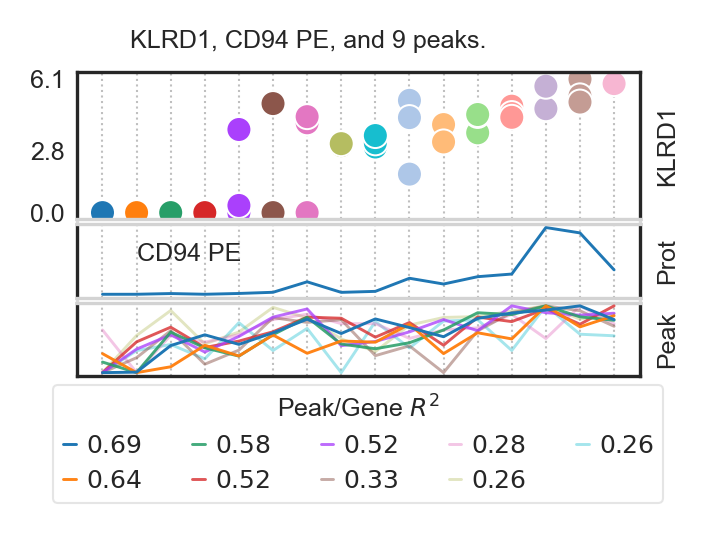

In [104]:
pgplot('KLRD1', protein='CD94 PE')

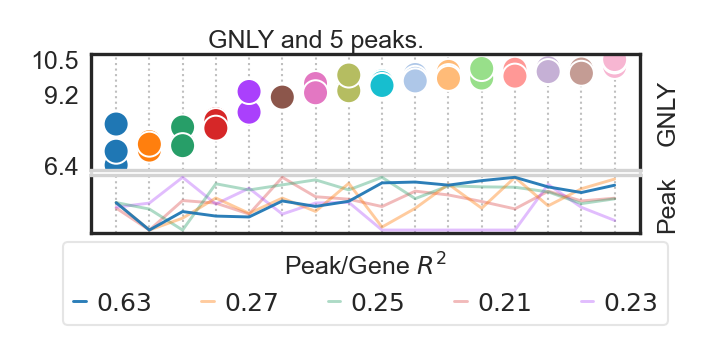

In [105]:
pgplot('GNLY')

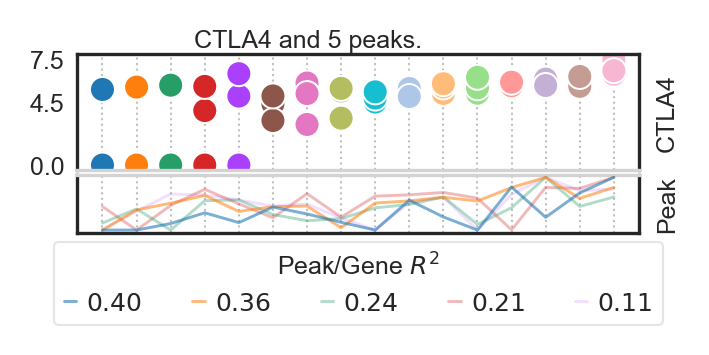

In [106]:
pgplot('CTLA4', window=50000, cutoff=0.05)

## Quick look at CTLA4

In [686]:
PCR_a = PCR_analysis('CTLA4', window=50000, verbose=True)
PCR_a

,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
Clone_ID,,,,,
P1_A03,0.108131,-0.127294,0.463815,0.647343,-0.958572
P1_A05,0.468872,0.278330,-0.824381,0.243862,0.377747
P1_A08,-0.960432,0.277748,0.241828,1.252980,1.101614
P1_A12,-0.628404,1.068183,-0.416881,0.885308,1.645937
P1_B10,-0.113053,-0.060938,-0.022482,-1.077174,0.595303
P1_C11,-0.268532,-0.342675,-0.480757,-0.025326,-0.748896
P1_D09,0.213048,0.201016,1.564668,0.870184,-3.126437
P1_F10,1.240361,1.037594,-0.403025,-0.371436,0.765693
P1_H01,0.239806,-0.291135,-0.927339,-0.158456,-1.471329


,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
Eigenpeak 0,1.000000e+00,3.089875e-08,3.127984e-09,4.827125e-08,1.082314e-07
Eigenpeak 1,3.089875e-08,1.000000e+00,9.393934e-09,1.638161e-08,1.362356e-08
Eigenpeak 2,3.127984e-09,9.393934e-09,1.000000e+00,-3.087906e-08,5.246818e-08
Eigenpeak 3,4.827125e-08,1.638161e-08,-3.087906e-08,1.000000e+00,-4.636430e-08
Eigenpeak 4,1.082314e-07,1.362356e-08,5.246818e-08,-4.636430e-08,1.000000e+00


PeakID,Interval_42078,Interval_42082,Interval_42083,Interval_42081,Interval_42076,Interval_42084,Interval_42079,Interval_42077,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,,,,
Interval_42078,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.330946,-0.316371,-0.593672,-0.520477,-0.408706
Interval_42077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.329080,0.782123,0.139561,-0.025039,-0.509790
Interval_42084,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.320385,-0.534450,0.597491,0.208118,-0.459792
Interval_42081,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.122882,-0.048133,-0.505103,0.786451,-0.330074
Interval_42082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815128,-0.015502,0.126297,-0.258184,-0.502708
CTLA4_R,0.628518,0.330031,-0.093321,0.460634,-0.007708,0.484888,-0.010952,0.603023,-0.453329,-0.025000,-0.242348,0.039257,-0.639627
CTLA4_Rsq,0.395035,0.10892,0.008709,0.212184,0.000059,0.235117,0.00012,0.363637,0.205507,0.000625,0.058732,0.001541,0.409122
CTLA4_promoter,False,True,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


In [692]:
eigen_df

PeakID,Eigenpeak 4,Eigenpeak 0,Eigenpeak 2,Eigenpeak 3,Eigenpeak 1
Clone_ID,,,,,
P1_A03,0.958572,-0.108131,-0.463815,-0.647343,0.127294
P1_A05,-0.377747,-0.468872,0.824381,-0.243862,-0.278330
P1_A08,-1.101614,0.960432,-0.241828,-1.252980,-0.277748
P1_A12,-1.645937,0.628404,0.416881,-0.885308,-1.068183
P1_B10,-0.595303,0.113053,0.022482,1.077174,0.060938
P1_C11,0.748896,0.268532,0.480757,0.025326,0.342675
P1_D09,3.126437,-0.213048,-1.564668,-0.870184,-0.201016
P1_F10,-0.765693,-1.240361,0.403025,0.371436,-1.037594
P1_H01,1.471329,-0.239806,0.927339,0.158456,0.291135


In [610]:
PCR_a.loc['CTLA4_Rsq'].sort_values(ascending=False)

PeakID
Eigenpeak 4       0.409122
Interval_42078    0.395035
Interval_42077    0.363637
Interval_42084    0.235117
Interval_42081    0.212184
Eigenpeak 0       0.205507
Interval_42082     0.10892
Eigenpeak 2       0.058732
Interval_42083    0.008709
Eigenpeak 3       0.001541
Eigenpeak 1       0.000625
Interval_42079     0.00012
Interval_42076    0.000059
Name: CTLA4_Rsq, dtype: object

In [621]:
peaklist

['Interval_42078',
 'Interval_42077',
 'Interval_42084',
 'Interval_42081',
 'Interval_42082']

In [649]:
PCR_df.loc['CTLA4_Rsq'].sort_values(ascending=False)

PeakID
Eigenpeak 4       0.409122
Interval_42078    0.395035
Interval_42077    0.363637
Interval_42084    0.235117
Interval_42081    0.212184
Eigenpeak 0       0.205507
Interval_42082     0.10892
Eigenpeak 2       0.058732
Interval_42083    0.008709
Eigenpeak 3       0.001541
Eigenpeak 1       0.000625
Interval_42079     0.00012
Interval_42076    0.000059
Name: CTLA4_Rsq, dtype: object

In [626]:
PCR_df.loc[peaklist, eigenpeaks]

PeakID,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,
Interval_42078,-0.330946,-0.316371,-0.593672,-0.520477,-0.408706
Interval_42077,-0.329080,0.782123,0.139561,-0.025039,-0.509790
Interval_42084,-0.320385,-0.534450,0.597491,0.208118,-0.459792
Interval_42081,0.122882,-0.048133,-0.505103,0.786451,-0.330074
Interval_42082,0.815128,-0.015502,0.126297,-0.258184,-0.502708


In [622]:
pplot_df[peaklist]

PeakID,Interval_42078,Interval_42077,Interval_42084,Interval_42081,Interval_42082
Clone_ID,,,,,
P1_A03,0.248868,0.621549,0.627037,0.713329,0.626639
P1_A05,0.305145,0.454215,0.176913,0.689303,0.494641
P1_A08,0.000000,0.511776,0.420038,0.643100,0.001047
P1_A12,0.000000,0.549927,0.107732,0.604463,0.000000
P1_B10,0.436589,0.444015,0.294898,0.234132,0.454044
P1_C11,0.565565,0.553225,0.485786,0.667828,0.520835
P1_D09,0.241993,1.000000,1.000000,0.809481,1.000000
P1_F10,0.123465,0.509719,0.000000,0.467209,0.683790
P1_H01,0.704050,0.599990,0.447591,0.789319,0.745944


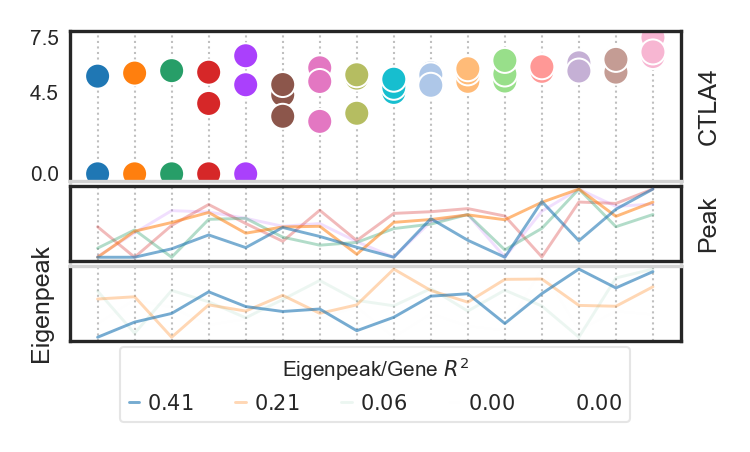

In [693]:
sns.set_style('white')

num_rows = 3
hr=[2,1,1]
        
fig, ax = plt.subplots(num_rows,1,figsize=(2.5,0.75*num_rows), dpi=300, sharex=True,
                        gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    
plt.rcParams['text.usetex'] = False
setfontsize()

gene = 'CTLA4'
PCR_df = PCR_analysis(gene, window=50000)
clone_order = list(gene_clonal[gene].sort_values().index)
    
gplot_df = pd.DataFrame(columns=[gene,'Clone'])
gplot_df[gene] = adata.to_df()[gene]
    
    
gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
clone_order = [clone for clone in clone_order if clone in pg_clones]

for clone in clone_order:
    for row in range(num_rows):
        ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
# GENE EXPRESSION PLOT
    
sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
ax[0].set_yticks(gene_ticks)
ax[0].set_yticklabels(gene_ticks, x=0.03)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].set_ylabel(gene)
ax[0].yaxis.set_label_position("right") 


# ATAC PLOT
peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > 0.05]
pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()

pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    
no_peaks = 0
for peak in peaklist:
    peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
    if peak_Rsq > 0.05:
        peak_label = '${:1.2f}$'.format(peak_Rsq)
        no_peaks += 1
    else:
        peak_label = None
    sns.lineplot(x='Clone', y=peak, data=pplot_df, ax=ax[1], linewidth=0.7,
                label=peak_label, alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int)) #, label=peak, legend=False)
    
ax[1].set_ylabel('Peak')
ax[1].yaxis.set_label_position("right")
ax[1].set_yticks([])
ax[1].set_xlabel('')
lgnd = ax[1].legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
                    loc=9, ncol=ncol, framealpha=0.5)
lgnd.get_frame().set_linewidth(0.5)

eigenpeaks = PCR_df.loc['CTLA4_Rsq'].sort_values(ascending=False).index
eigenpeaks = [epeak for epeak in eigenpeaks if epeak[:5] == 'Eigen']

realpeaks = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
realpeaks = realpeaks.loc[pg_clones]
normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
eigen_df = -normpeaks[peaklist].dot(PCR_df.loc[peaklist, eigenpeaks])
eigen_df['Clone'] = pd.Categorical(eigen_df.index, categories = clone_order, ordered = True)
eigen_df[eigenpeaks] = (eigen_df[eigenpeaks] - eigen_df[eigenpeaks].min()) #/ pplot_df[peaklist].max()
eigen_df[eigenpeaks] = eigen_df[eigenpeaks] / eigen_df[eigenpeaks].max()
no_peaks = 0
for epeak in eigenpeaks:
    peak_Rsq = PCR_df.loc[gene+'_Rsq',epeak]
    if peak_Rsq > 0.00:
        peak_label = '${:1.2f}$'.format(peak_Rsq)
        no_peaks += 1
    else:
        peak_label=None
    sns.lineplot(x='Clone', y=epeak, data=eigen_df, ax=ax[2], linewidth=0.7, label=peak_label,
                alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int))
ax[2].set_ylabel('Eigenpeak')
#ax[2].yaxis.set_label_position("right")
ax[2].set_yticks([])
ax[2].set_xlabel('')

# Plot legend
if no_peaks <= 6:
    ncol = no_peaks
else:
    ncol = (no_peaks + 1)//2
lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Eigenpeak/Gene $R^2$',  
                    loc=9, ncol=ncol, framealpha=0.5)
lgnd.get_frame().set_linewidth(0.5)

ax[0].spines['bottom'].set_color('lightgray')
ax[-1].spines['top'].set_color('lightgray')
    
plt.xticks(rotation=45)
plt.xticks([])
    
# Save and show figure.
set_size(fig, (2.5, 1.5))
plt.savefig("Panels/MultiPlots/CTLA_Illustration.pdf".format(gene), bbox_inches='tight')
plt.show()
    

In [752]:
peaklist = ['Interval_{}'.format(j) for j in ['42078','42082','42077','42084','42081']]

In [753]:
pplot_df[peaklist].corr()

PeakID,Interval_42078,Interval_42082,Interval_42077,Interval_42084,Interval_42081
PeakID,,,,,
Interval_42078,1.000000,0.606840,0.537666,0.331798,0.241727
Interval_42082,0.606840,1.000000,0.704926,0.623627,0.315173
Interval_42077,0.537666,0.704926,1.000000,0.651000,0.420423
Interval_42084,0.331798,0.623627,0.651000,1.000000,0.399781
Interval_42081,0.241727,0.315173,0.420423,0.399781,1.000000


In [754]:
eigen_df[eigenpeaks].corr()

PeakID,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,
Eigenpeak 0,1.000000e+00,3.089875e-08,3.127984e-09,4.827125e-08,1.082314e-07
Eigenpeak 1,3.089875e-08,1.000000e+00,9.393934e-09,1.638161e-08,1.362356e-08
Eigenpeak 2,3.127984e-09,9.393934e-09,1.000000e+00,-3.087906e-08,5.246818e-08
Eigenpeak 3,4.827125e-08,1.638161e-08,-3.087906e-08,1.000000e+00,-4.636430e-08
Eigenpeak 4,1.082314e-07,1.362356e-08,5.246818e-08,-4.636430e-08,1.000000e+00


In [755]:
pe_df = PCR_df.loc[peaklist, eigenpeaks]
pe_df

PeakID,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,
Interval_42078,-0.330946,-0.316371,-0.593672,-0.520477,-0.408706
Interval_42082,0.815128,-0.015502,0.126297,-0.258184,-0.502708
Interval_42077,-0.329080,0.782123,0.139561,-0.025039,-0.509790
Interval_42084,-0.320385,-0.534450,0.597491,0.208118,-0.459792
Interval_42081,0.122882,-0.048133,-0.505103,0.786451,-0.330074


In [756]:
mm = 1/25.4

In [761]:
mask = np.zeros((5,5)).astype(bool)
for i in range(5):
    for j in range(i+1):
        mask[i,j] = True
mask

array([[ True, False, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True]])

PeakID,Interval_42078,Interval_42082,Interval_42083,Interval_42081,Interval_42076,Interval_42084,Interval_42079,Interval_42077,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,,,,
Interval_42078,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.330946,-0.316371,-0.593672,-0.520477,-0.408706
Interval_42077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.329080,0.782123,0.139561,-0.025039,-0.509790
Interval_42084,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.320385,-0.534450,0.597491,0.208118,-0.459792
Interval_42081,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.122882,-0.048133,-0.505103,0.786451,-0.330074
Interval_42082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815128,-0.015502,0.126297,-0.258184,-0.502708
CTLA4_R,0.628518,0.330031,-0.093321,0.460634,-0.007708,0.484888,-0.010952,0.603023,-0.453329,-0.025000,-0.242348,0.039257,-0.639627
CTLA4_Rsq,0.395035,0.10892,0.008709,0.212184,0.000059,0.235117,0.00012,0.363637,0.205507,0.000625,0.058732,0.001541,0.409122
CTLA4_promoter,False,True,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


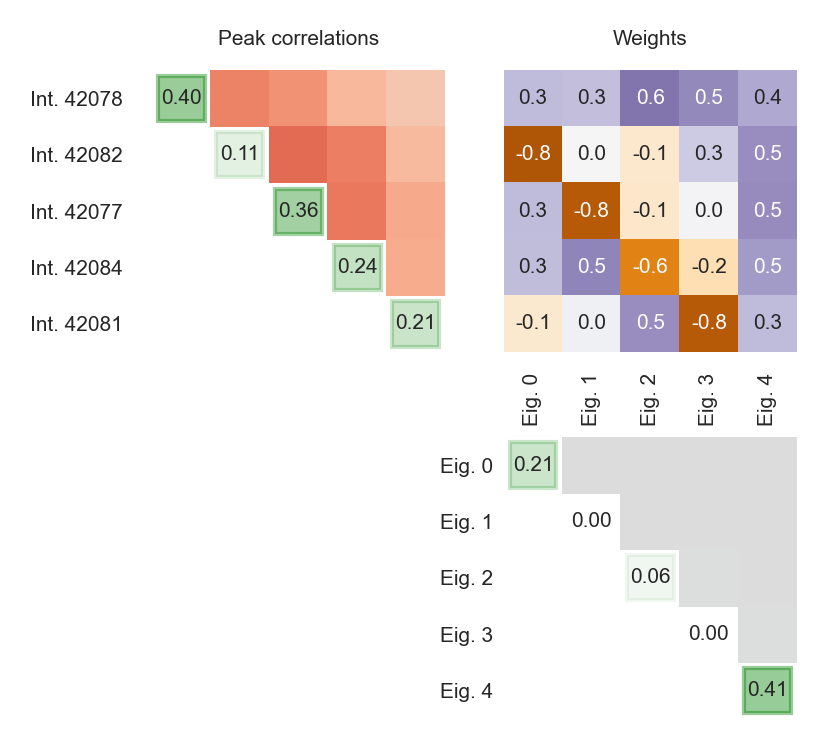

In [783]:
fig,ax = plt.subplots(2,2,figsize=(70*mm, 70*mm), dpi=300, gridspec_kw={'hspace':0.3})

sns.heatmap(pplot_df[peaklist].corr(), ax=ax[0,0], cbar=None, vmin=-1.0, vmax=1.0, cmap='coolwarm',
           mask=mask)

for j,peak in enumerate(peaklist):
    alpha = PCR_df.loc['CTLA4_Rsq',peak]
    ax[0,0].add_patch(Rectangle((j+0.1,j+0.1),0.8,0.8, color='green', fill=True, clip_on=False,
                               alpha=alpha))
    ax[0,0].text(j+0.5, j+0.5, '{:.2f}'.format(alpha), ha='center', va='center')
    
sns.heatmap(eigen_df[eigenpeaks].corr(), ax=ax[1,1],cbar=None, vmin=-1.0, vmax=1.0, cmap='coolwarm',
           mask=mask)

for j,peak in enumerate(eigenpeaks):
    alpha = PCR_df.loc['CTLA4_Rsq',peak]
    ax[1,1].add_patch(Rectangle((j+0.1,j+0.1),0.8,0.8, color='green', fill=True, clip_on=False,
                               alpha=alpha))
    ax[1,1].text(j+0.5, j+0.5, '{:.2f}'.format(alpha), ha='center', va='center')

sns.heatmap(-pe_df, ax=ax[0,1], vmin=-1, vmax=1, cmap='PuOr', cbar=None, annot=True, fmt='1.1f')

peaklabels = ['Int. {}'.format(peak.split('_')[1]) for peak in peaklist]
eigenlabels = ['Eig. {}'.format(peak[-1]) for peak in eigenpeaks]
ax[0,0].set_yticklabels(peaklabels)
ax[0,0].set_xticklabels([])
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')
ax[1,0].set_visible(False)
ax[1,1].set_yticklabels(eigenlabels)
ax[1,1].set_xticklabels(eigenlabels, rotation=90)
ax[1,1].tick_params(labelbottom=False,labeltop=True, pad=-1)
ax[0,1].set_yticklabels([])
ax[0,1].set_ylabel('')
ax[0,1].set_xticklabels([])
ax[0,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')
ax[0,0].set_title('Peak correlations')
ax[0,1].set_title('Weights')
plt.show()

In [701]:
eigenpeaks.sort()
eigenpeaks

['Eigenpeak 0', 'Eigenpeak 1', 'Eigenpeak 2', 'Eigenpeak 3', 'Eigenpeak 4']

In [705]:
peaklist.sort()
peaklist

['Interval_42077',
 'Interval_42078',
 'Interval_42081',
 'Interval_42082',
 'Interval_42084']

In [706]:
super_df = pd.concat([pplot_df[peaklist], eigen_df[eigenpeaks]], axis=1)
super_df

PeakID,Interval_42077,Interval_42078,Interval_42081,Interval_42082,Interval_42084,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
Clone_ID,,,,,,,,,,
P1_A03,0.621549,0.248868,0.713329,0.626639,0.627037,0.514465,0.636864,0.383914,0.163273,0.637540
P1_A05,0.454215,0.305145,0.689303,0.494641,0.176913,0.350550,0.420777,0.833162,0.272046,0.414112
P1_A08,0.511776,0.000000,0.643100,0.001047,0.420038,1.000000,0.421087,0.461330,0.000000,0.293084
P1_A12,0.549927,0.000000,0.604463,0.000000,0.107732,0.849132,0.000000,0.691049,0.099120,0.202075
P1_B10,0.444015,0.436589,0.234132,0.454044,0.294898,0.614966,0.601514,0.553506,0.628182,0.377738
P1_C11,0.553225,0.565565,0.667828,0.520835,0.485786,0.685613,0.751603,0.713325,0.344616,0.602483
P1_D09,1.000000,0.241993,0.809481,1.000000,1.000000,0.466792,0.461964,0.000000,0.103197,1.000000
P1_F10,0.509719,0.123465,0.467209,0.683790,0.000000,0.000000,0.016296,0.686217,0.437924,0.349249
P1_H01,0.599990,0.704050,0.789319,0.745944,0.447591,0.454634,0.724146,0.869067,0.380507,0.723271


In [707]:
super_df.corr()

PeakID,Interval_42077,Interval_42078,Interval_42081,Interval_42082,Interval_42084,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,,,,,,
Interval_42077,1.000000,0.537666,0.420423,0.704926,0.651000,1.714466e-01,-4.268257e-01,-1.095565e-01,2.279758e-02,8.808539e-01
Interval_42078,0.537666,1.000000,0.241727,0.606840,0.331798,1.724188e-01,1.726523e-01,4.660381e-01,4.738812e-01,7.061926e-01
Interval_42081,0.420423,0.241727,1.000000,0.315173,0.399781,-6.401988e-02,2.626736e-02,3.965108e-01,-7.160434e-01,5.703268e-01
Interval_42082,0.704926,0.606840,0.315173,1.000000,0.623627,-4.246714e-01,8.459622e-03,-9.914426e-02,2.350695e-01,8.686169e-01
Interval_42084,0.651000,0.331798,0.399781,0.623627,1.000000,1.669165e-01,2.916637e-01,-4.690356e-01,-1.894857e-01,7.944633e-01
Eigenpeak 0,0.171447,0.172419,-0.064020,-0.424671,0.166917,1.000000e+00,3.089875e-08,3.127984e-09,4.827125e-08,1.082314e-07
Eigenpeak 1,-0.426826,0.172652,0.026267,0.008460,0.291664,3.089875e-08,1.000000e+00,9.393934e-09,1.638161e-08,1.362356e-08
Eigenpeak 2,-0.109557,0.466038,0.396511,-0.099144,-0.469036,3.127984e-09,9.393934e-09,1.000000e+00,-3.087906e-08,5.246818e-08
Eigenpeak 3,0.022798,0.473881,-0.716043,0.235069,-0.189486,4.827125e-08,1.638161e-08,-3.087906e-08,1.000000e+00,-4.636430e-08


In [709]:
PCR_df.loc[peaklist, eigenpeaks]

PeakID,Eigenpeak 0,Eigenpeak 1,Eigenpeak 2,Eigenpeak 3,Eigenpeak 4
PeakID,,,,,
Interval_42077,-0.329080,0.782123,0.139561,-0.025039,-0.509790
Interval_42078,-0.330946,-0.316371,-0.593672,-0.520477,-0.408706
Interval_42081,0.122882,-0.048133,-0.505103,0.786451,-0.330074
Interval_42082,0.815128,-0.015502,0.126297,-0.258184,-0.502708
Interval_42084,-0.320385,-0.534450,0.597491,0.208118,-0.459792


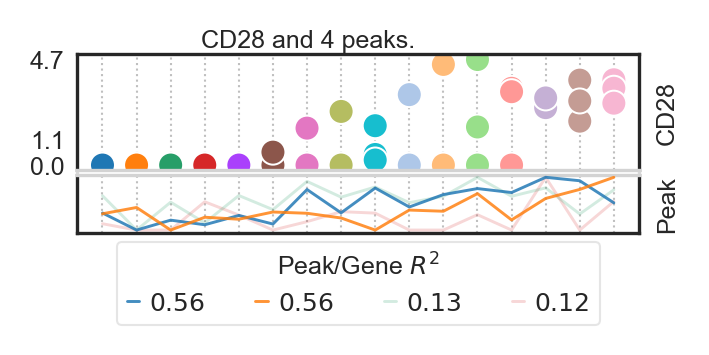

In [107]:
pgplot('CD28', cutoff=0.1, window=50000)

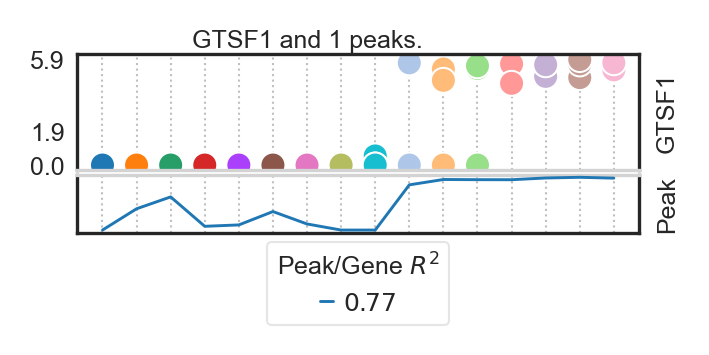

In [108]:
pgplot('GTSF1', window=50000)

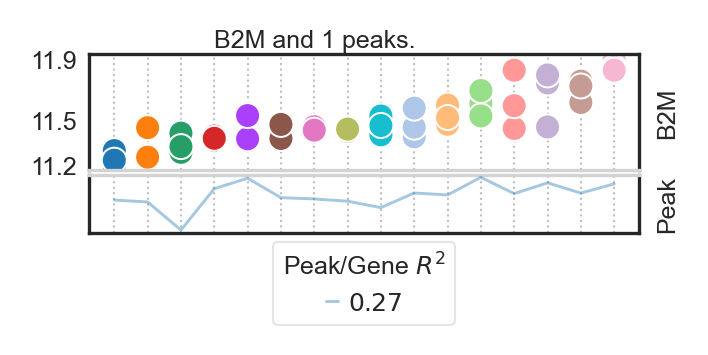

In [109]:
pgplot('B2M', window=50000)

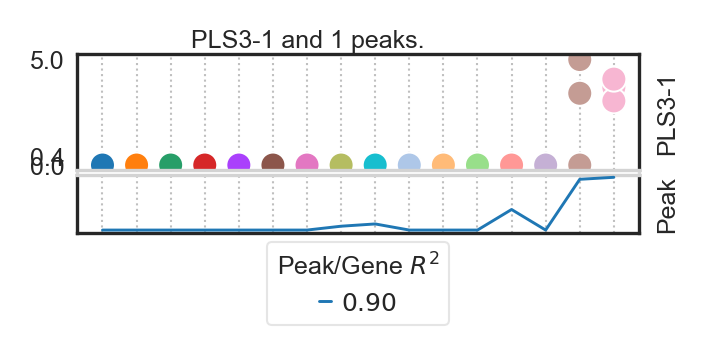

In [110]:
pgplot('PLS3-1', cutoff=0.2, window=50000)

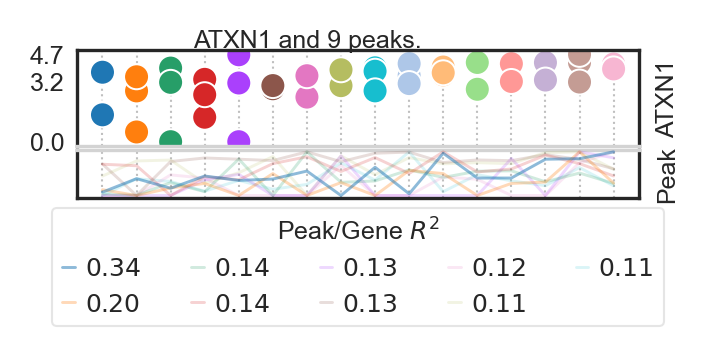

In [111]:
pgplot('ATXN1', cutoff=0.1)

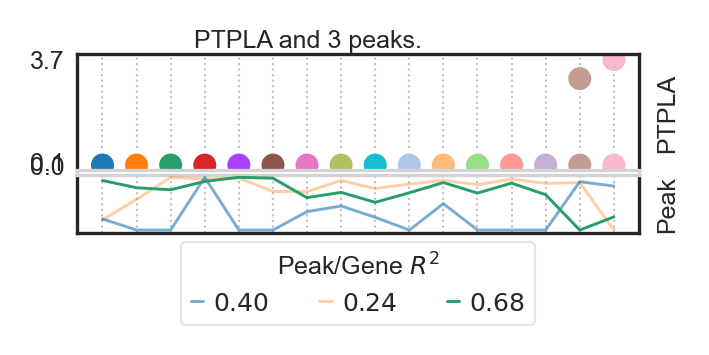

In [112]:
pgplot('PTPLA', window=100000)

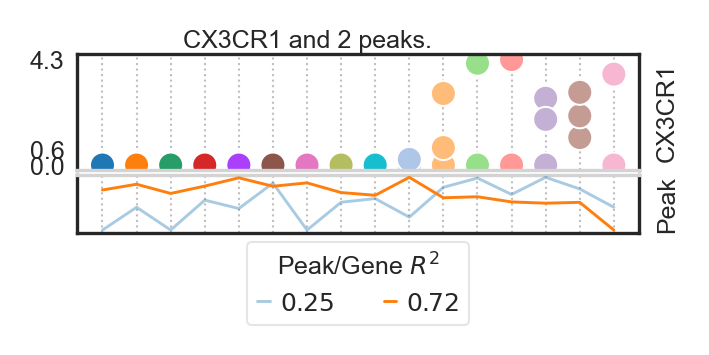

In [113]:
pgplot('CX3CR1')

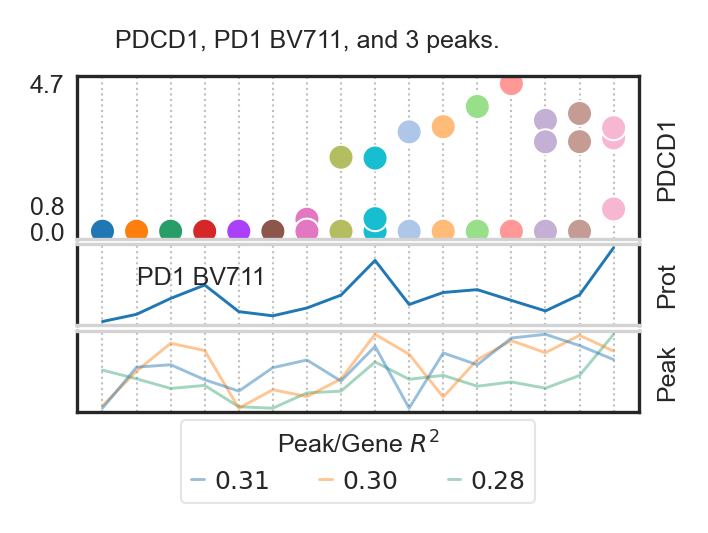

In [114]:
pgplot('PDCD1', protein='PD1 BV711')

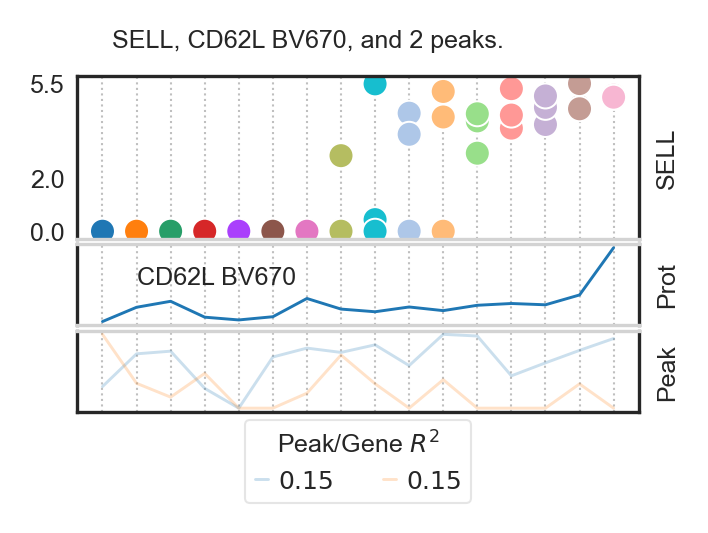

In [115]:
pgplot('SELL', protein='CD62L BV670', cutoff=0.1, window=100000)

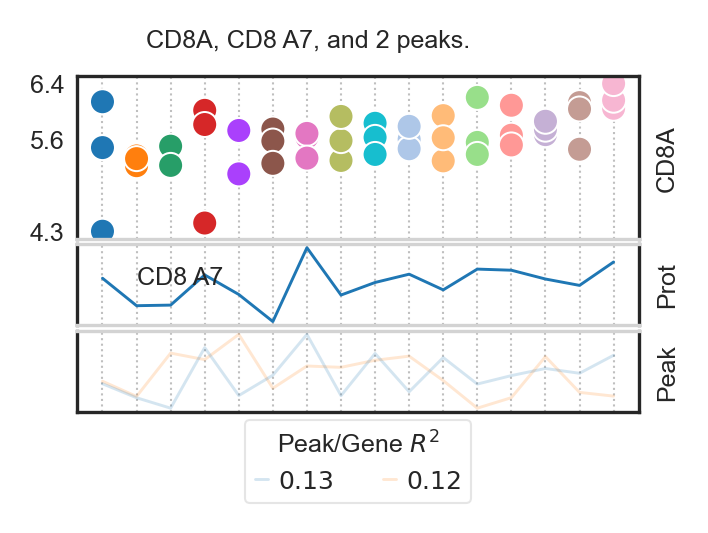

In [116]:
pgplot('CD8A', protein='CD8 A7', cutoff=0.1, window=100000)

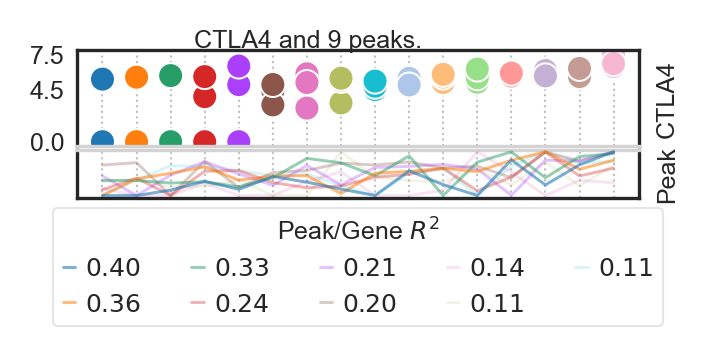

In [117]:
pgplot('CTLA4', cutoff=0.1, window=200000)

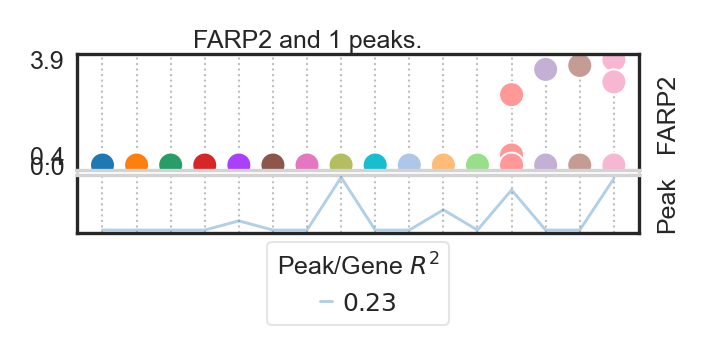

In [118]:
pgplot('FARP2')

# Interactive plots with plotly

In [368]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [416]:
clone_order = list(gene_clonal['GNLY'].sort_values().index)
GNLY_df = pd.DataFrame(adata[adata.obs.Clone_ID.isin(clone_order)].to_df()['GNLY'])
GNLY_df['Clone'] = adata.obs.Clone_ID
GNLY_df['CloneNo'] = GNLY_df['Clone'].apply(lambda cl : clone_order.index(cl))
GNLY_df = GNLY_df.sort_values(by = 'CloneNo')
GNLY_df['Obs'] = GNLY_df.index
GNLY_df.to_csv('GNLY.csv')

In [418]:
GNLY_df.head()

,GNLY,Clone,CloneNo,Obs
obs_names,,,,
P9855_2064,6.443704,P2_G01,0,P9855_2064
P9855_2065,6.977074,P2_G01,0,P9855_2065
P9855_2066,8.026063,P2_G01,0,P9855_2066
P9855_2052,7.343882,P2_B11,1,P9855_2052
P9855_2054,7.248993,P2_B11,1,P9855_2054


In [509]:
PCR_df = PCR_analysis('GNLY', window=50000)
peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
peaklist = [peak for peak in peaklist if PCR_df.loc['GNLY_Rsq',peak] > 0.2]
pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()    
pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
pplot_df

PeakID,Interval_38960,Interval_38958,Interval_38952,Interval_38957,Interval_38954
Clone_ID,,,,,
P1_A03,0.853715,0.957707,0.606178,0.673972,0.182904
P1_A05,0.366227,0.286637,0.033572,0.637745,1.000000
P1_A08,0.938414,0.457004,0.825354,0.622371,0.000000
P1_A12,0.822138,0.498161,0.732897,0.782813,0.864407
P1_B10,1.000000,0.987676,0.817911,0.507326,0.000000
P1_C11,0.896599,0.133382,1.000000,0.543578,0.000000
P1_D09,0.266482,0.369553,0.767923,0.426492,0.793042
P1_D12,0.841212,0.067638,0.606178,0.000000,0.000000
P1_F02,0.555491,0.479262,0.688567,0.819367,0.924218


In [510]:
pplot_df = pplot_df.melt(ignore_index = False)

In [511]:
pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
pplot_df.head()
pplot_df

,PeakID,value,Clone,CloneNo
Clone_ID,,,,
P1_A03,Interval_38960,0.853715,P1_A03,15
P1_A05,Interval_38960,0.366227,P1_A05,2
P1_A08,Interval_38960,0.938414,P1_A08,11
P1_A12,Interval_38960,0.822138,P1_A12,13
P1_B10,Interval_38960,1.000000,P1_B10,12
...,...,...,...,...
P2_B11,Interval_38954,0.511519,P2_B11,1
P2_G01,Interval_38954,0.433055,P2_G01,0
P2_G09,Interval_38954,0.000000,P2_G09,10


In [528]:
pplot_df['R'] = pplot_df['PeakID'].map(PCR_ans['GNLY'].loc['GNLY_R'])
pplot_df['R_sq'] = pplot_df['R']**2
pplot_df['Peak location'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'mid'])
#pplot_df['end'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'end'])
pplot_df = pplot_df.sort_values(by=['CloneNo','R_sq'])
pplot_df

,PeakID,value,Clone,CloneNo,R,R_sq,start,end,Peak location
Clone_ID,,,,,,,,,
P2_G01,Interval_38957,0.519999,P2_G01,0,0.459019,0.210699,85906050,85906710,85906380.0
P2_G01,Interval_38954,0.433055,P2_G01,0,-0.478716,0.229169,85875121,85875499,85875310.0
P2_G01,Interval_38952,0.537168,P2_G01,0,0.50086,0.250861,85864333,85865223,85864778.0
P2_G01,Interval_38958,0.553895,P2_G01,0,0.517197,0.267493,85907781,85909113,85908447.0
P2_G01,Interval_38960,0.530982,P2_G01,0,0.793927,0.63032,85920961,85922036,85921498.5
...,...,...,...,...,...,...,...,...,...
P1_A03,Interval_38957,0.673972,P1_A03,15,0.459019,0.210699,85906050,85906710,85906380.0
P1_A03,Interval_38954,0.182904,P1_A03,15,-0.478716,0.229169,85875121,85875499,85875310.0
P1_A03,Interval_38952,0.606178,P1_A03,15,0.50086,0.250861,85864333,85865223,85864778.0


85912298

In [573]:
import altair as alt
gene_chart = alt.Chart(GNLY_df).mark_circle(size=100).encode(
    x={"field": "Clone",
      "type": "ordinal",
       "sort" : clone_order,
       "axis" : alt.Axis(labels=False, title=" ")},
    y='GNLY',
    color='Clone',
    tooltip=['Clone', 'Obs', 'GNLY']
).interactive().properties(
    width=400,
    height=200
)

highlight = alt.selection(type='single', on='mouseover',
                          fields=['PeakID'], nearest=True)

TSS = adata.var.loc['GNLY','TSS']

peak_base = alt.Chart(pplot_df).encode(
    x={"field": "Clone",
               "type": "ordinal",
               "sort" : clone_order},
    y={"field" : "value",
       "type": "quantitative",
       "axis" : alt.Axis(labels=False, title="Peak height")},
    color=alt.Color("PeakID")
)

# interval selection in the bar chart
pts = alt.selection_multi(encodings=["x"])

points = peak_base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=400
)

peak_chart = peak_base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)), #,
    opacity=alt.Opacity("R_sq", legend=None),
    tooltip=['Clone', 'PeakID', 'value']#,
    ).transform_filter(pts).interactive().properties(
    width=400,
    height=100
)

peak_chart = points + peak_chart


peakR_chart = alt.Chart(pplot_df).mark_bar().encode(
    x={"field":"Peak location", 
       "type":"quantitative",
       "axis":alt.Axis(values=[TSS-50000, TSS, TSS+50000])},
    y="R",
    text="PeakID",
    color="PeakID",
    opacity=alt.condition(~highlight, alt.value(0.1), alt.value(1.0)),
    tooltip=['PeakID','R','R_sq']
    #color=alt.condition(
    #    alt.datum.R > 0,
    #    alt.value("steelblue"),  # The positive color
    #    alt.value("orange")  # The negative color
    #)
).interactive().properties(
    width=300,
    height=50).add_selection(pts)



TSS_line = alt.Chart(pd.DataFrame({'TSS': [TSS]})).mark_rule().encode(
    x=alt.X('TSS'))

peakR_chart = peakR_chart + TSS_line

#peakR_chart = peakR_chart + peakR_text

#peaks_chart = alt.hconcat(peak_chart, peakR_chart)

chart = alt.vconcat(gene_chart, peak_chart, peakR_chart).resolve_scale(
    color='independent')

chart

alt.VConcatChart(...)

In [567]:
chart.save('GNLY.json')

In [402]:
def pgplotly(gene, protein = None, cutoff=0.2, window=50000):
    if protein:
        num_rows = 3
        specs=[[{"type": "scatter"}],
               [{"type": "line"}],
               [{"type": "line"}]]
    else:
        num_rows = 2
        specs=[[{"type": "scatter"}],
               [{"type": "scatter"}]]
        
    #fig, ax = plt.subplots(num_rows,1,figsize=(2.5,0.75*num_rows), dpi=300, sharex=True,
    #                       gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    #
    #plt.rcParams['text.usetex'] = False
    #setfontsize()

    fig = make_subplots(
        rows=num_rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        specs=specs
    )




    PCR_df = PCR_analysis(gene, window=window)
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    
    
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
    clone_order = [clone for clone in clone_order if clone in pg_clones]
    gplot_df['CloneNo'] = gplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    gplot_df = gplot_df.sort_values(by='CloneNo')
    gplot_df['Text'] = ''
    for row in gplot_df.index:
        expr = gplot_df.loc[row,gene]
        cl = gplot_df.loc[row,'Clone']
        gplot_df.loc[row,'Text'] = '{} expression {:1.3f} in Clone {}.'.format(gene,expr,cl)
    col_range = list(range(len(gplot_df)))
    #for clone in clone_order:
    #    for row in range(num_rows):
    #        ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    fig.add_trace(
        go.Scatter(
            x=gplot_df['Clone'],
            y=gplot_df[gene],
            mode="markers",
            marker=dict(size=16, 
                        color=gplot_df['CloneNo'], 
                        colorscale=px.colors.qualitative.Dark24),
            text=gplot_df['Text'],
            name="{} expression".format(gene)
        ),
        row=1, col=1)
    
    #sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
    #gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
    #ax[0].set_yticks(gene_ticks)
    #ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax[0].set_ylabel(gene)
    #ax[0].yaxis.set_label_position("right")
    
    # ATAC PLOT
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
    pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    pplot_df = pplot_df.sort_values(by='CloneNo')
    #
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        fig.add_trace(
            go.Scatter(
                x=pplot_df['Clone'],
                y=pplot_df[peak],
                mode="lines",
                #text=gplot_df['Text'],
                name=peak
            ),
            row=2, col=1)
        
    
    
    # PROTEIN PLOT
    #if protein:
    #    proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
    #    proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
    #    proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
    #    proplot_df['Clone'] = proplot_df.index
    #    sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
    #    ax[1].text(1,0.5,protein, ha='left')
    #    ax[1].set_ylabel('Prot')
    #    ax[1].yaxis.set_label_position("right")
    #    ax[1].set_yticks([])
    #    ax[1].set_xlabel('')
    #    ax[1].spines['top'].set_color('lightgray')
    #    ax[1].spines['bottom'].set_color('lightgray')
    

    if protein:
        title = '{}, {}, and {} peaks.'.format(gene, protein, len(peaklist))
    else:
        title = '{} and {} peaks.'.format(gene, len(peaklist))
    #plt.suptitle(title, y=1.02)
    
    # Plot legend
    #if no_peaks <= 6:
    #    ncol = no_peaks
    #else:
    #    ncol = (no_peaks + 1)//2
    #lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
    #                  loc=9, ncol=ncol, framealpha=0.5)
    #lgnd.get_frame().set_linewidth(0.5)
    
    # Save and show figure.
    #set_size(fig, (2.5, 1.5))
    #plt.savefig("Panels/MultiPlots/{}_multi.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    fig.show()
    fig.write_html("Plotly/{}_plotly.html".format(gene), include_plotlyjs=False)
    

In [403]:
pgplotly('GNLY')

# Summary panel

<ipython-input-219-8939d6f8e3a2>:55: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog',linthreshy=20.0)


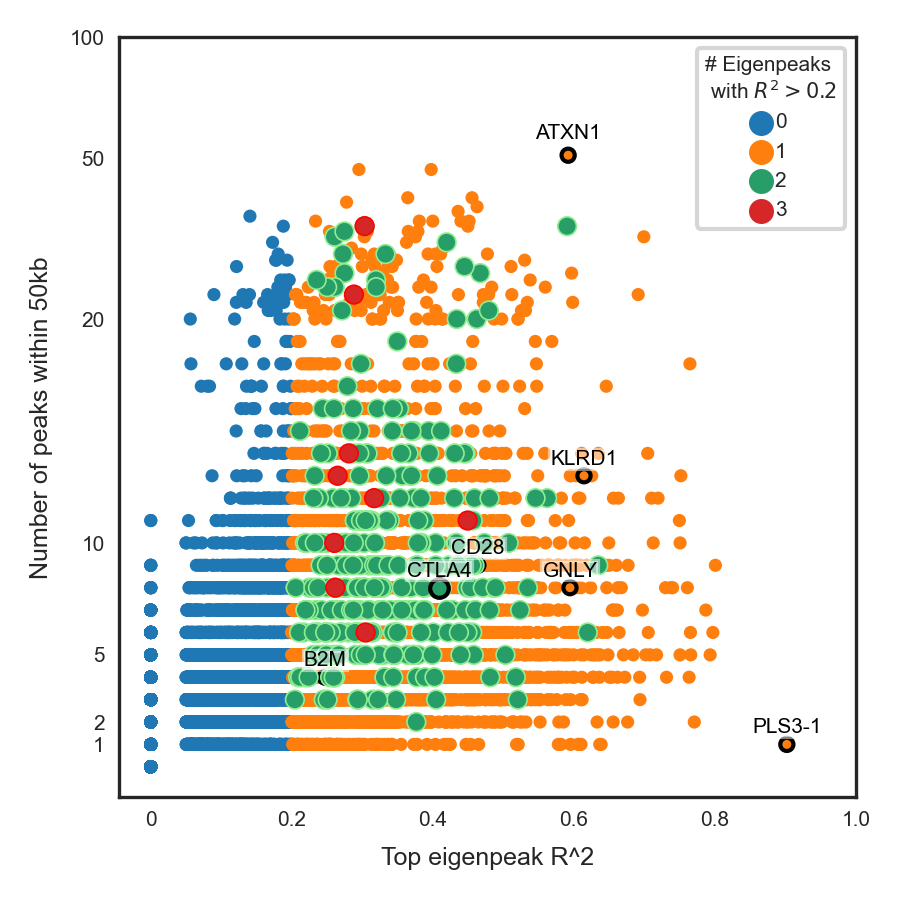

In [219]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(3,3), dpi=300)

n_max = PCR_summary.num_eig.max()
plot_df = pd.DataFrame(index=PCR_summary.index)
plot_df['Top eigenpeak R^2'] = PCR_summary['eigen0_R_sq'].fillna(0)
plot_df['Number of peaks within 50kb'] = PCR_summary['num_peaks']
plot_df['Number of eigenpeaks \n with R^2 > 0.2'] = PCR_summary['num_eig'].astype('category')

complex_genes = PCR_summary[PCR_summary.num_eig > 4].index
peaky_genes = PCR_summary[PCR_summary.num_peaks > 50].index
eigen_genes = PCR_summary[PCR_summary.eigen0_R_sq > 0.75].index
ann_genes = complex_genes.union(peaky_genes).union(eigen_genes)

ann_genes = ['KLRD1', 'GNLY', 'PLS3-1', 'B2M', 'CD28', 'CTLA4', 'ATXN1']
for n in range(n_max+1):
    p_df = plot_df[plot_df['Number of eigenpeaks \n with R^2 > 0.2'] == n]
    if n > 1:
        ec = 'lightgreen'
        lw = 0.4
        s=20
        if n > 2:
            ec = 'red'
    else:
        ec = None
        lw = 0
        s=10
    if n == 0:
        leg = True
    else:
        leg = False
    
    if n == 2:
        for gene in ann_genes:
            x = plot_df.loc[gene, 'Top eigenpeak R^2']
            y = plot_df.loc[gene, 'Number of peaks within 50kb']
            if y < 20:
                y_loc = y + 0.5
            else:
                y_loc = y*1.1
            ax.text( x,y_loc, gene, color='black', ha='center',
                    bbox = dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
    
    sns.scatterplot(x='Top eigenpeak R^2', y='Number of peaks within 50kb', 
                    hue = 'Number of eigenpeaks \n with R^2 > 0.2', 
                    edgecolor=ec, linewidth = lw, s=s, data=p_df, ax=ax, legend=leg)
    
    ag = [gene for gene in ann_genes if gene in p_df.index]
    sns.scatterplot(x='Top eigenpeak R^2', y='Number of peaks within 50kb', 
                    hue = 'Number of eigenpeaks \n with R^2 > 0.2', 
                    edgecolor='k', linewidth = 1.0, s=s, data=p_df.loc[ag], ax=ax, legend=False)


    
ax.set_yscale('symlog',linthreshy=20.0)
ax.set_yticks([1,2,5,10,20,50,100])
ax.set_yticklabels([1,2,5,10,20,50,100], x=0.02)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], y=0.02)
lgnd = plt.legend(title='# Eigenpeaks \n with $R^2 > 0.2$', bbox_to_anchor=(1.0, 1), loc='upper right')
for j in range(4):
    lgnd.legendHandles[j]._sizes = [25]
set_size(fig, (3, 3))
plt.savefig("Panels/PCR_allgenes.pdf", bbox_inches='tight')
plt.show()

# Analysis of genes near variable peaks

This part is a bit exploratory...

We might want to find peaks within a window around a gene too.

In [230]:
ATAC_data.var.loc['Interval_1111']

PeakID         Interval_1111
chr                        1
end                 27060826
in_ensg      ENSG00000117713
in_gene               ARID1A
itype                 intron
mid               27060469.0
start               27060112
quality_p           0.874316
clonal_p            0.043424
Name: Interval_1111, dtype: object

In [232]:
adata.var

,ENSG,F_pval,GC_content,TSS,chr,dir,end,gene_name,highly_variable,highly_variable_rank,...,mt,n_cells,n_cells_by_counts,n_counts,pct_dropout_by_counts,start,total_counts,transcript_length,variances,variances_norm
gene_name,,,,,,,,,,,,,,,,,,,,,
WASH7P,ENSG00000227232,0.614609,54.66,29570,1,-1,29806,WASH7P,1,3596.0,...,0,8,8,49.0,88.571429,14363,8.158915,1560.40,7.082609,1.273521
AL627309.1,ENSG00000237683,0.084300,64.43,139379,1,-1,139379,AL627309.1,1,4638.0,...,0,4,4,49.0,94.285714,134901,3.892857,2661.00,21.024638,1.169311
RP11-34P13.13,ENSG00000241860,0.000560,44.96,149707,1,1,173862,RP11-34P13.13,1,906.0,...,0,4,4,53.0,94.285714,141474,6.409715,1739.25,11.635818,1.685184
MTND2P28,ENSG00000225630,0.499452,43.10,565020,1,1,566063,MTND2P28,0,NaN,...,0,67,67,2635.0,4.285714,565020,204.195953,1044.00,388.754658,0.070277
hsa-mir-6723,ENSG00000237973,0.021039,45.76,566454,1,1,567996,hsa-mir-6723,0,NaN,...,0,63,63,951.0,10.000000,566454,107.216347,1543.00,137.753416,0.087748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EIF4A1P2,ENSG00000235001,0.493847,48.28,5207005,Y,-1,5207005,EIF4A1P2,0,NaN,...,0,13,13,16.0,81.428571,5205786,5.800146,1207.00,0.265839,0.621265
SRIP3,ENSG00000224953,0.456939,50.68,6587221,Y,-1,6587221,SRIP3,0,NaN,...,0,59,59,202.0,15.714286,6587003,130.002487,219.00,6.131677,0.049281
AC010970.2,ENSG00000225840,0.000101,51.25,10036711,Y,-1,10036711,AC010970.2,0,NaN,...,0,69,69,54393.0,1.428571,10036113,455.836182,599.00,162582.070600,0.855552


In [233]:
def genes_near(peak, window=50000):
    if peak[:8] == 'Interval':
        pk = peak
    else:
        pk = 'Interval_'+peak # No need to enter Interval_ in input.
    pk_info = ATAC_data.var.loc[pk]
    g_df = adata.var[adata.var['chr'] == pk_info['chr']]
    g_df = g_df[np.abs(g_df.start + g_df.end - 2*pk_info['mid']) < window]
    return g_df.index

In [240]:
genes_near('11500', window=100000)

Index(['RRAS2'], dtype='object', name='gene_name')

In [263]:
peaks_clonal = ATAC_data.var[ATAC_data.var.quality_p > 0.1]
peaks_clonal = peaks_clonal.clonal_p.sort_values()[:500]
peaks_clonal

PeakID
Interval_32862    0.000504
Interval_50252    0.000504
Interval_45444    0.000504
Interval_53611    0.000504
Interval_12456    0.000504
                    ...   
Interval_15220    0.000504
Interval_39346    0.000504
Interval_207      0.000504
Interval_71396    0.000504
Interval_63853    0.000504
Name: clonal_p, Length: 500, dtype: float64

In [265]:
genes_peakclonal = [list(genes_near(peak)) for peak in peaks_clonal.index]
genes_peakclonal = [item for itemlist in genes_peakclonal for item in itemlist]
genes_peakclonal = set(genes_peakclonal)
print('{} genes found within 50kb of a clonal peak.'.format(len(genes_peakclonal)))

145 genes found within 50kb of a clonal peak.


<AxesSubplot:xlabel='F_pval', ylabel='Count'>

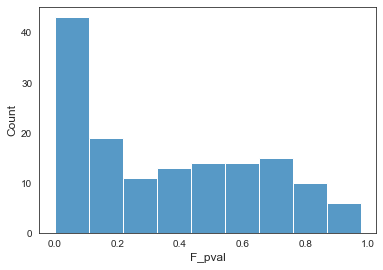

In [266]:
desetfontsize()
sns.histplot(adata.var.loc[genes_peakclonal].F_pval)

<AxesSubplot:xlabel='F_pval', ylabel='Count'>

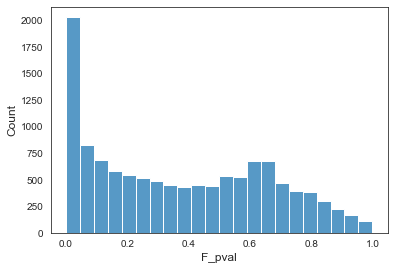

In [267]:
sns.histplot(adata.var.F_pval)